# Problem Statement

Lending Club wants to understand the driving factors (or driver variables) behind loan default, i.e. the variables which are strong indicators of default.  The company can utilise this knowledge for its portfolio and risk assessment.  
Two types of risks are associated with the bank’s decision:  

* If the applicant is likely to repay the loan, then not approving the loan results in a loss of business to the company  

* If the applicant is not likely to repay the loan, i.e. he/she is likely to default, then approving the loan may lead to a financial loss for the company  
  
The provided data contains the information about past loan applicants and whether they ‘defaulted’ or not. The aim is to identify patterns which indicate if a person is likely to default, which may be used for taking actions such as denying the loan, reducing the amount of loan, lending (to risky applicants) at a higher interest rate, etc.  
  
When a person applies for a loan, there are two types of decisions that could be taken by the company:  

1. Loan accepted: If the company approves the loan, there are 3 possible scenarios described below:

 * Fully paid: Applicant has fully paid the loan (the principal and the interest rate)

 * Current: Applicant is in the process of paying the instalments, i.e. the tenure of the loan is not yet completed. These candidates are not labelled as 'defaulted'.

 * Charged-off: Applicant has not paid the instalments in due time for a long period of time, i.e. he/she has defaulted on the loan 

2. Loan rejected: The company had rejected the loan (because the candidate does not meet their requirements etc.). This data is not part of provided data set

# Data Understanding

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import missingno as msno
import seaborn as sns
import numpy as np
from statsmodels.graphics.mosaicplot import mosaic
import scipy.stats as ss

In [2]:
# Load the loan data
loan_all_df = pd.read_csv("loan.csv", low_memory=False)
loan_all_df.shape

(39717, 111)

In [3]:
loan_all_df.describe()

,id,member_id,loan_amnt,funded_amnt,funded_amnt_inv,installment,annual_inc,dti,delinq_2yrs,inq_last_6mths,...,num_tl_90g_dpd_24m,num_tl_op_past_12m,pct_tl_nvr_dlq,percent_bc_gt_75,pub_rec_bankruptcies,tax_liens,tot_hi_cred_lim,total_bal_ex_mort,total_bc_limit,total_il_high_credit_limit
count,3.971700e+04,3.971700e+04,39717.000000,39717.000000,39717.000000,39717.000000,3.971700e+04,39717.000000,39717.000000,39717.000000,...,0.0,0.0,0.0,0.0,39020.000000,39678.0,0.0,0.0,0.0,0.0
mean,6.831319e+05,8.504636e+05,11219.443815,10947.713196,10397.448868,324.561922,6.896893e+04,13.315130,0.146512,0.869200,...,NaN,NaN,NaN,NaN,0.043260,0.0,NaN,NaN,NaN,NaN
std,2.106941e+05,2.656783e+05,7456.670694,7187.238670,7128.450439,208.874874,6.379377e+04,6.678594,0.491812,1.070219,...,NaN,NaN,NaN,NaN,0.204324,0.0,NaN,NaN,NaN,NaN
min,5.473400e+04,7.069900e+04,500.000000,500.000000,0.000000,15.690000,4.000000e+03,0.000000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
25%,5.162210e+05,6.667800e+05,5500.000000,5400.000000,5000.000000,167.020000,4.040400e+04,8.170000,0.000000,0.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
50%,6.656650e+05,8.508120e+05,10000.000000,9600.000000,8975.000000,280.220000,5.900000e+04,13.400000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
75%,8.377550e+05,1.047339e+06,15000.000000,15000.000000,14400.000000,430.780000,8.230000e+04,18.600000,0.000000,1.000000,...,NaN,NaN,NaN,NaN,0.000000,0.0,NaN,NaN,NaN,NaN
max,1.077501e+06,1.314167e+06,35000.000000,35000.000000,35000.000000,1305.190000,6.000000e+06,29.990000,11.000000,8.000000,...,NaN,NaN,NaN,NaN,2.000000,0.0,NaN,NaN,NaN,NaN


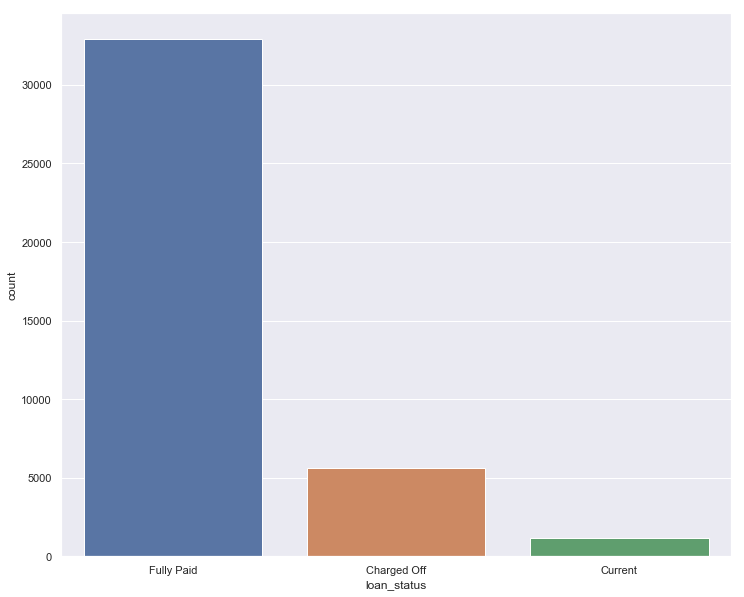

In [4]:
sns.set(rc={'figure.figsize':(12,10)})
sns.countplot(loan_all_df.loan_status)

In [5]:
# Keep only the rows where loan_status is not Current
loan_df = loan_all_df.loc[loan_all_df.loan_status != 'Current']
loan_df.shape

(38577, 111)

# Data Cleaning and Manipulation

## Data Sanity Checks

In [6]:
# Find out percentage of missing values in each column
columns = loan_df.columns
percent_missing = loan_df.isnull().sum() * 100 / len(loan_df)
missing_value_df = pd.DataFrame({'column_name': columns,
                                 'percent_missing': percent_missing})
missing_value_df.sort_values('percent_missing', ascending = False, inplace=True)
missing_value_df[missing_value_df.percent_missing == 100]

,column_name,percent_missing
verification_status_joint,verification_status_joint,100.0
annual_inc_joint,annual_inc_joint,100.0
mo_sin_old_rev_tl_op,mo_sin_old_rev_tl_op,100.0
mo_sin_old_il_acct,mo_sin_old_il_acct,100.0
bc_util,bc_util,100.0
bc_open_to_buy,bc_open_to_buy,100.0
avg_cur_bal,avg_cur_bal,100.0
acc_open_past_24mths,acc_open_past_24mths,100.0
inq_last_12m,inq_last_12m,100.0
total_cu_tl,total_cu_tl,100.0


In [7]:
# list the columns that have 100% missing values
list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name'])

['verification_status_joint',
 'annual_inc_joint',
 'mo_sin_old_rev_tl_op',
 'mo_sin_old_il_acct',
 'bc_util',
 'bc_open_to_buy',
 'avg_cur_bal',
 'acc_open_past_24mths',
 'inq_last_12m',
 'total_cu_tl',
 'inq_fi',
 'total_rev_hi_lim',
 'all_util',
 'max_bal_bc',
 'open_rv_24m',
 'open_rv_12m',
 'il_util',
 'total_bal_il',
 'mths_since_rcnt_il',
 'open_il_24m',
 'open_il_12m',
 'open_il_6m',
 'open_acc_6m',
 'tot_cur_bal',
 'tot_coll_amt',
 'mo_sin_rcnt_rev_tl_op',
 'mo_sin_rcnt_tl',
 'mort_acc',
 'num_rev_tl_bal_gt_0',
 'total_bc_limit',
 'total_bal_ex_mort',
 'tot_hi_cred_lim',
 'percent_bc_gt_75',
 'pct_tl_nvr_dlq',
 'num_tl_op_past_12m',
 'num_tl_90g_dpd_24m',
 'num_tl_30dpd',
 'num_tl_120dpd_2m',
 'num_sats',
 'num_rev_accts',
 'mths_since_recent_bc',
 'num_op_rev_tl',
 'num_il_tl',
 'num_bc_tl',
 'num_bc_sats',
 'num_actv_rev_tl',
 'num_actv_bc_tl',
 'num_accts_ever_120_pd',
 'mths_since_recent_revol_delinq',
 'mths_since_recent_inq',
 'mths_since_recent_bc_dlq',
 'dti_joint',
 '

In [8]:
# drop columns that have 100% mising values
loan_df.drop(columns=list(missing_value_df.loc[missing_value_df.percent_missing == 100,'column_name']),inplace = True)
loan_df.shape

C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\pandas\core\frame.py:3697: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame

See the caveats in the documentation: http://pandas.pydata.org/pandas-docs/stable/indexing.html#indexing-view-versus-copy
  errors=errors)


(38577, 56)

In [9]:
# find out columns that have 0 standard deviation
loan_df.std()[loan_df.std() == 0]

out_prncp                     0.0
out_prncp_inv                 0.0
collections_12_mths_ex_med    0.0
policy_code                   0.0
acc_now_delinq                0.0
chargeoff_within_12_mths      0.0
delinq_amnt                   0.0
tax_liens                     0.0
dtype: float64

In [10]:
# dropping column with standard deviation 0
loan_df.drop(loan_df.std()[loan_df.std() == 0.0].index.values, axis=1,inplace = True)
loan_df.shape

(38577, 48)

In [11]:
# checking whether there are columns having single values. Standard deviation check will not work for non-numeric columns
uniques = loan_df.apply(lambda x: x.nunique())
uniques[uniques==1]

pymnt_plan             1
initial_list_status    1
application_type       1
dtype: int64

In [12]:
# dropping columns having single values
loan_df = loan_df.drop(uniques[uniques==1].index, axis=1)
loan_df.shape

(38577, 45)

## Business understanding

In [13]:
# Drop columns that will not be available at the time of aproving loan
columns_to_remove = ['last_credit_pull_d',
                     'last_pymnt_amnt',
                    'collection_recovery_fee',
                     'delinq_2yrs',
                     'mths_since_last_delinq',
                     'last_pymnt_d',
                     'recoveries',
                     'total_pymnt',
                     'total_pymnt_inv',
                     'total_rec_int',
                     'total_rec_late_fee',
                     'total_rec_prncp'
                    ]
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 33)

## Data Understanding

In [14]:
# Drop columns that will can not have any impact
columns_to_remove = ['title' , # very high variance
                     'emp_title', # very high variance
                     'zip_code' # very high variance
                    ]
loan_df.drop(columns_to_remove , axis = 1 , inplace = True)
loan_df.shape

(38577, 30)

In [15]:
# checking whether there are duplicate rows
loan_df.duplicated().sum()

0

In [16]:
# Check potential unique value fields 
df_colunique = pd.DataFrame(loan_df.nunique()/loan_df.count())
# Columns having all unique values excludeing Nulls
df_colunique.loc[df_colunique[0] >= 0.99]

,0
id,1.000000
member_id,1.000000
url,1.000000
desc,0.990518


In [17]:
# drop the columns where each row has unique values
loan_df.drop(df_colunique.loc[df_colunique[0] >= 0.99].index, axis=1, inplace= True)
loan_df.shape

(38577, 26)

In [18]:
# Strip all columns for leading and lagging spaces

loan_df = loan_df.applymap(lambda s : s.strip() if type(s) is str else s)

In [19]:
# Remove string months from term 6 

loan_df.term = loan_df.term.apply(lambda s : s[0:s.index(' ')] if ' ' in s else s)
loan_df.term = pd.to_numeric(loan_df.term)
loan_df.term.head()

0    36
1    60
2    36
3    36
5    36
Name: term, dtype: int64

In [20]:
# Remove % sign from interest rate 
loan_df.int_rate = loan_df.int_rate.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.int_rate = pd.to_numeric(loan_df.int_rate)
loan_df.int_rate.head()

0    10.65
1    15.27
2    15.96
3    13.49
5     7.90
Name: int_rate, dtype: float64

In [21]:
loan_df.info()

<class 'pandas.core.frame.DataFrame'>
Int64Index: 38577 entries, 0 to 39716
Data columns (total 26 columns):
loan_amnt                 38577 non-null int64
funded_amnt               38577 non-null int64
funded_amnt_inv           38577 non-null float64
term                      38577 non-null int64
int_rate                  38577 non-null float64
installment               38577 non-null float64
grade                     38577 non-null object
sub_grade                 38577 non-null object
emp_length                37544 non-null object
home_ownership            38577 non-null object
annual_inc                38577 non-null float64
verification_status       38577 non-null object
issue_d                   38577 non-null object
loan_status               38577 non-null object
purpose                   38577 non-null object
addr_state                38577 non-null object
dti                       38577 non-null float64
earliest_cr_line          38577 non-null object
inq_last_6mths           

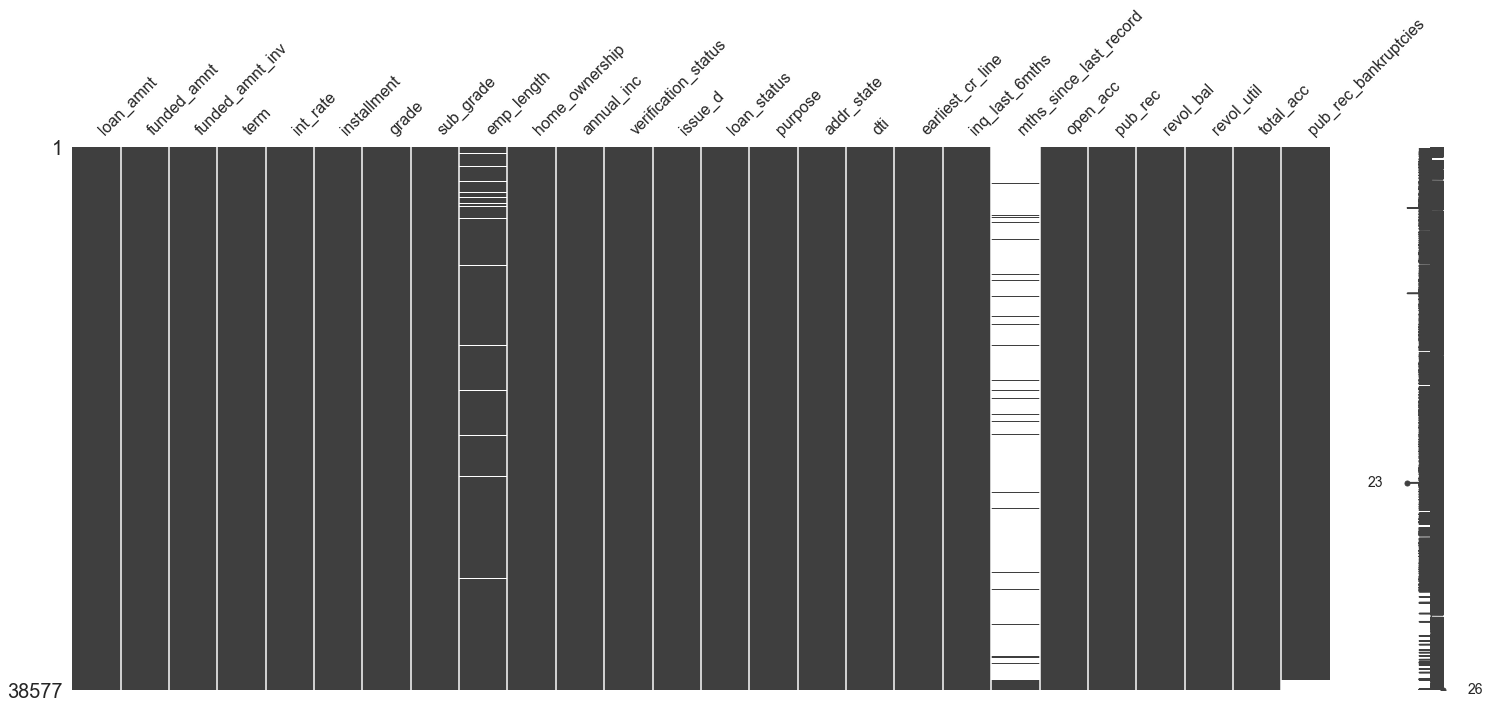

In [22]:
# visualize missing data
msno.matrix(loan_df)

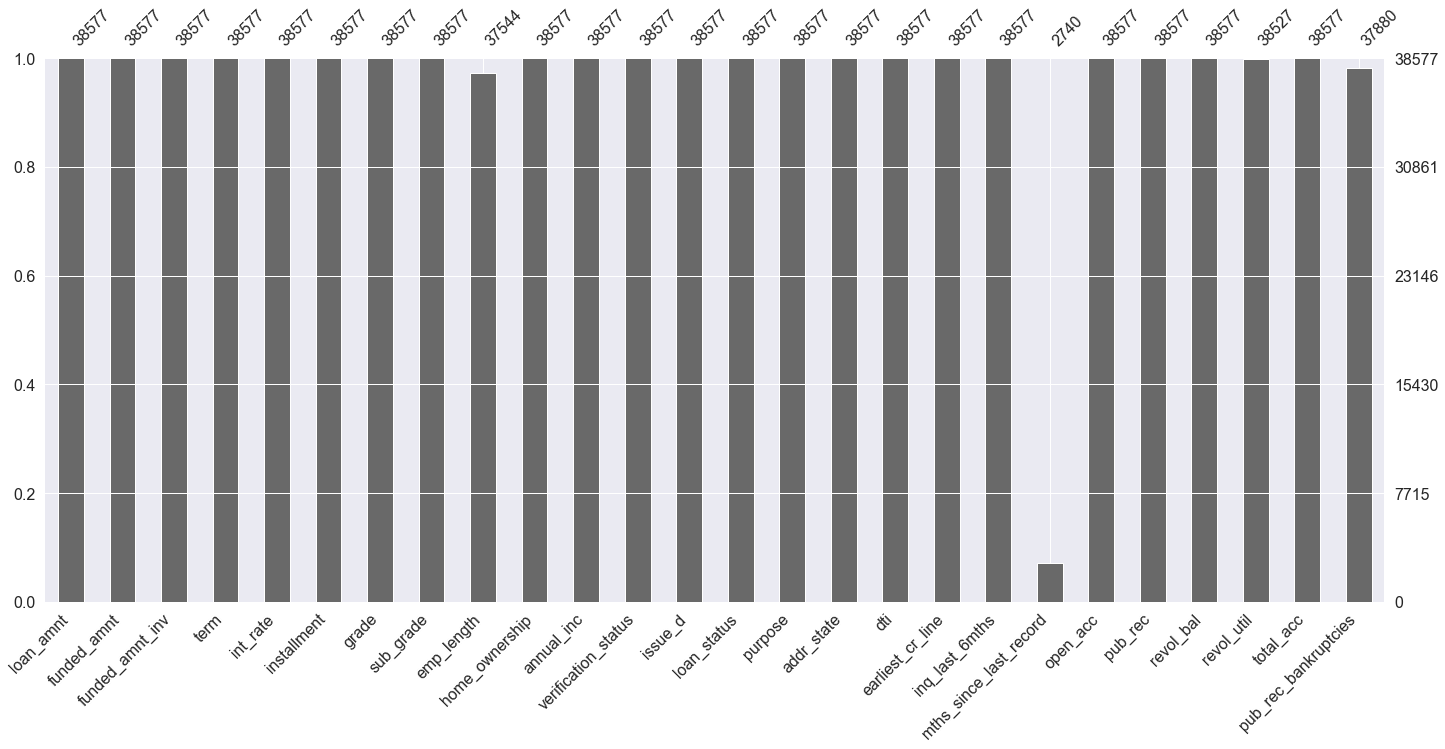

In [23]:
msno.bar(loan_df)

The missingno correlation heatmap measures nullity correlation: how strongly the presence or absence of one variable affects the presence of another:

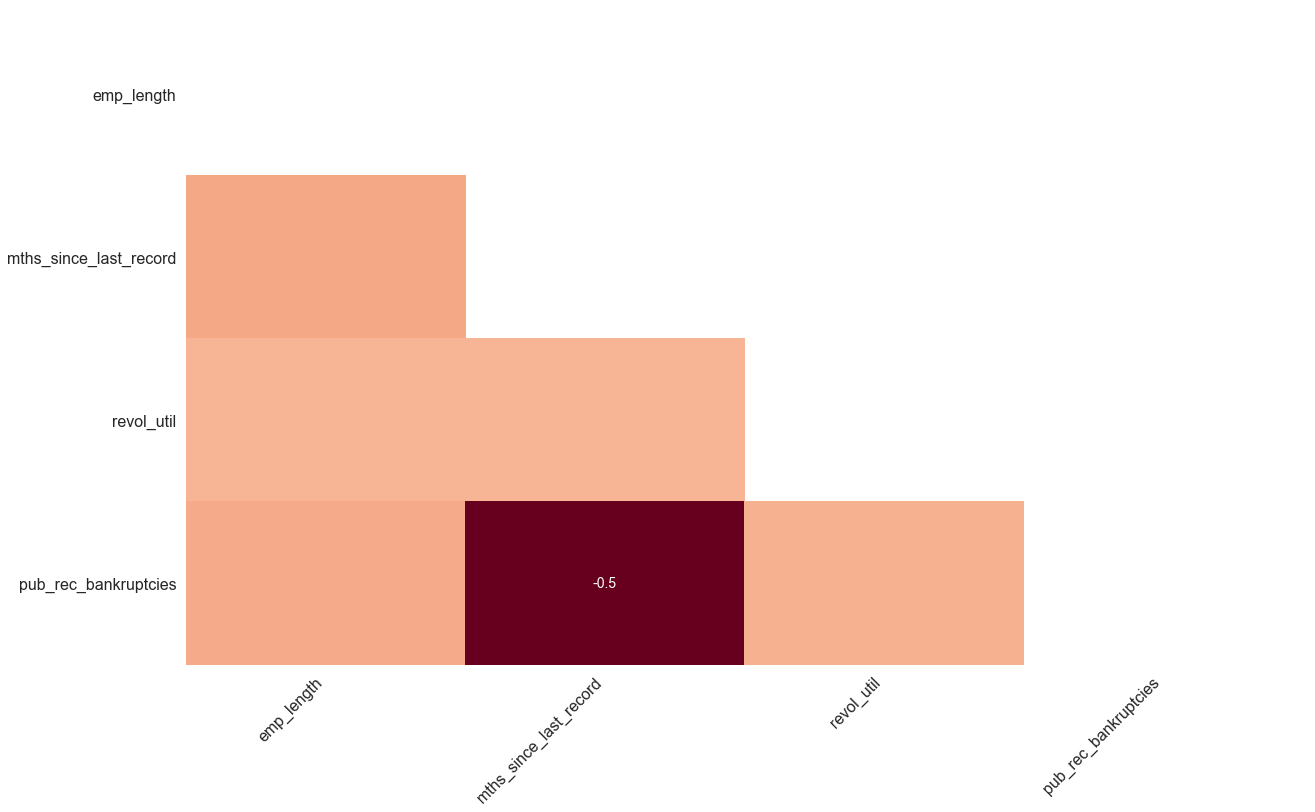

In [24]:
msno.heatmap(loan_df)

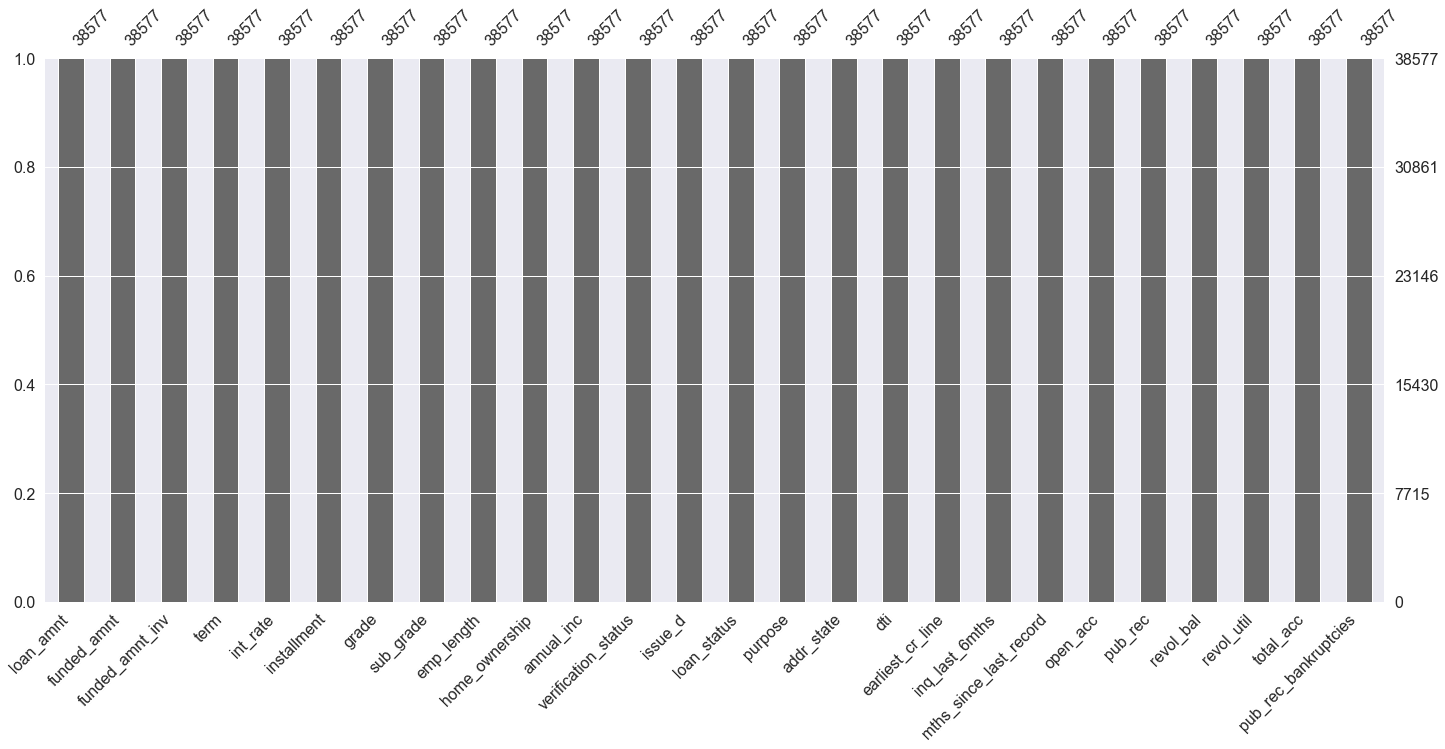

In [25]:
# Impute missing values
values = {'emp_length': 'NA', 'revol_util': '0%', 'mths_since_last_record': -1, 'pub_rec_bankruptcies':0}
loan_df.fillna(value=values, inplace = True)
msno.bar(loan_df)

In [26]:
# Remove % sign from interest rate 
loan_df.revol_util = loan_df.revol_util.apply(lambda s : s[0:s.index('%')] if '%' in s else s)
loan_df.revol_util = pd.to_numeric(loan_df.revol_util)
loan_df.revol_util.head()

0    83.7
1     9.4
2    98.5
3    21.0
5    28.3
Name: revol_util, dtype: float64

In [27]:
# writing load data frame with reduced columns in a csv
#loan_df.to_csv('loan_df_reduced.csv')

# Data analysis

## Custom Functions

### Univariate and segmented univariate analysis on categorical variables

In [28]:
# Perform Univariate Analysis

# Write Function to perform univariate analysis on categorical variables 

def uni_analysis_cat (x , summary = 0):
    print(x.iloc[:,0].describe())
    sns.set(rc={'figure.figsize':(15,6)})
    x.iloc[:,0].value_counts().plot(kind='barh')
    f, axes = plt.subplots(1, 2)
       
    if(~summary):
        print('****************************************************************************************************')
        sns.countplot( x = x.iloc[:,0], data = x , ax = axes[0])
        sns.countplot( x = x.iloc[:,0], hue = x.iloc[:,1] , data = x , ax = axes[1] )
        for ax in f.axes:
            plt.sca(ax)
            plt.xticks(rotation=90)
        plt.legend(bbox_to_anchor=(1.05, 1), loc=2, borderaxespad=0.)
        
        labelizer = lambda k: ''
        mosaic(x.sort_values(list(x.columns)[0]),
               list(x.columns),
               label_rotation = [90,0], 
               labelizer=labelizer)

### Univariate and segmented univariate analysis for quantitative variable 

In [29]:
# Univariate analysis for quantitative variable 


def uni_analysis_num (x , type = 'r', log_scale=False):
    sns.set(rc={'figure.figsize':(15,6)})
    f, axes = plt.subplots(1, 3)
    
    #print('Variable =' , x.columns[0])
    #print('Mean Value ', round(x.iloc[:,0].mean(),2) )
    #print('Median ', round(x.iloc[:,0].median(),2) )
    print(round(x.iloc[:,0].describe(),2))
   
    print('****************************************************************************************************')
    # for each unique value in 2nd column
    for value in list(x.iloc[:,1].unique()):
        a = x.loc[x.iloc[:,1] == value,list(x.columns)[0]]
        a.rename(index = value, inplace = True)
        p1=sns.kdeplot(a, shade=True)
    if log_scale: p1.set_xscale('log')
    bp = sns.boxplot( y = x.iloc[:,0], data = x , ax = axes[0])
    if log_scale: bp.set_yscale('log')
    vp = sns.violinplot( x = x.iloc[:,1] , y = x.iloc[:,0] , data = x , ax = axes[1], \
                   vert = True , inner = 'quartile' ,scale_hue = True )
    if log_scale: vp.set_yscale('log')


### Bubble Plot to visualise date dependency

In [30]:
def bubble_plot(x , y , z ,percent):
    plt.rcParams.update({'font.size': 12})

    plt.figure(figsize=(10, 6))
    
    plt.scatter(x = x
                , y = y , 
                s = percent * 100,
                c = 'r',
               alpha = 0.8)

    
    for i in range(0,len(x)):
        plt.text(x[i] ,y[i], s= percent[i].round(2) , ha = 'left', va = 'center', fontsize = 12)

    plt.show()

### Bivariate Analysis for quantitave variables

In [31]:
# Bivariate analysis : Common function to perform correlation within data frame 

def bi_analysis_num(df):
    sns.set(rc={'figure.figsize':(15,6)})
    f, axes = plt.subplots(1, 2)
    
    #sns.heatmap(df.corr(), fmt='0.2f', annot=True , cmap = 'Greens')
    dfc = df[df.loan_status == 'Charged Off']
    dff = df[df.loan_status == 'Fully Paid']
    
    sns.kdeplot(dfc.iloc[:,0] , dfc.iloc[:,1] ,  cmap="Reds", shade=True, shade_lowest=False , ax = axes[0])
    sns.kdeplot(dff.iloc[:,0] , dff.iloc[:,1] ,  cmap="Blues", shade=True, shade_lowest=False , ax = axes[1])

### Bivariate analysis for Quantitative variable

In [32]:
# Bivariate analysis for categorical variables : Common function to perform correlation within data frame 

def bi_analysis_cat(df):
    sns.set(rc={'figure.figsize':(15,6)})
   
    
    ct = pd.crosstab(df.iloc[:,1] , df.iloc[:,2] , margins = True , \
                     margins_name = 'Total' , normalize = True).round(4) * 100
    
    print(ct)
       
    sns.violinplot( x = df.iloc[:,1] , y = df.iloc[:,0] ,  hue = df.iloc[:,2] , data = df , \
                   vert = True , inner = 'quartile' ,scale_hue = True , split = True , annot = True )
    
    

### Independent t test

In [33]:
# Function to perform t-test for 2 independent data sets 
# Not usable yet

def independant_ttest(x , y ):
    stat , p = ss.ttest_ind(x, y , equal_var = False)
   
    print('p value = ' , round(p,4))
    
    if ( p < 0.05):
        print('The 2 sets of data differ significantly')
    else:
        print('We cannot state that the 2 sets of data differ significantly')

### Chi-squared test

In [34]:

# Create a function for a 2 set test using Pearsons's chi2 method
# https://stattrek.com/chi-square-test/independence.aspx

def chi2_cat_pearson(df):
    ctab = pd.crosstab(df.iloc[:,0] , df.iloc[:,1])
    stat , p , dof , expected = ss.chi2_contingency(ctab)
    
    print('p value is =', round(p,4))
    
    if ( p < 0.05):
        print('The 2 data sets are not independent of each other ')
    else:
        print('The 2 data sets are independent of each other')

## Analysis of consumer attributes

### `addr_state`: The state provided by the borrower in the loan application

count     38577
unique       50
top          CA
freq       6949
Name: addr_state, dtype: object
****************************************************************************************************


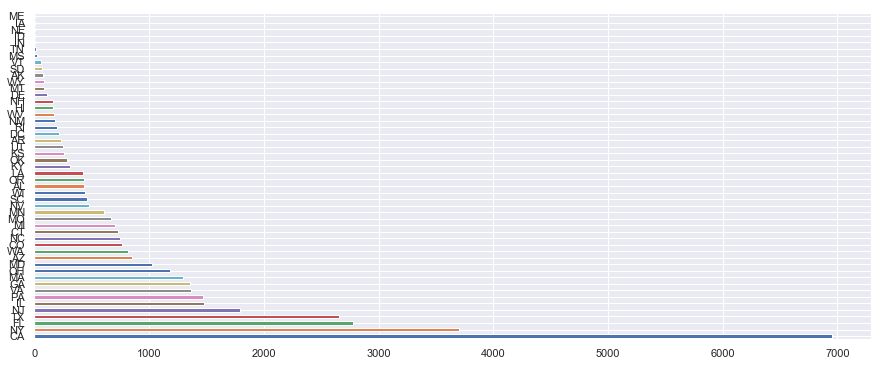

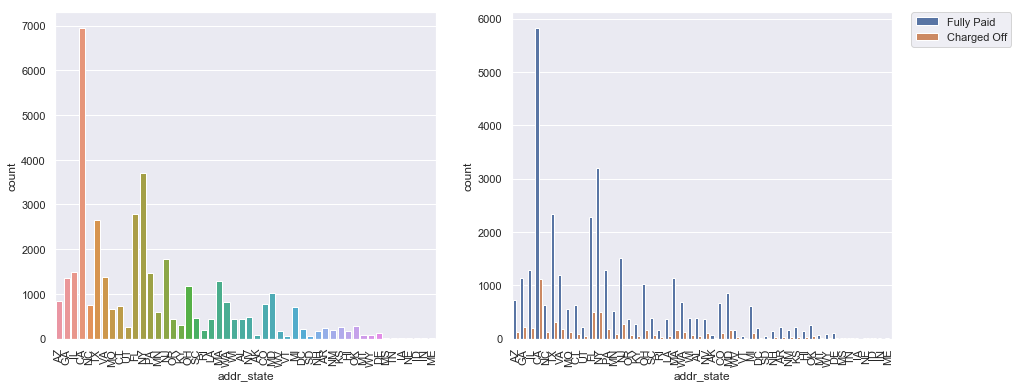

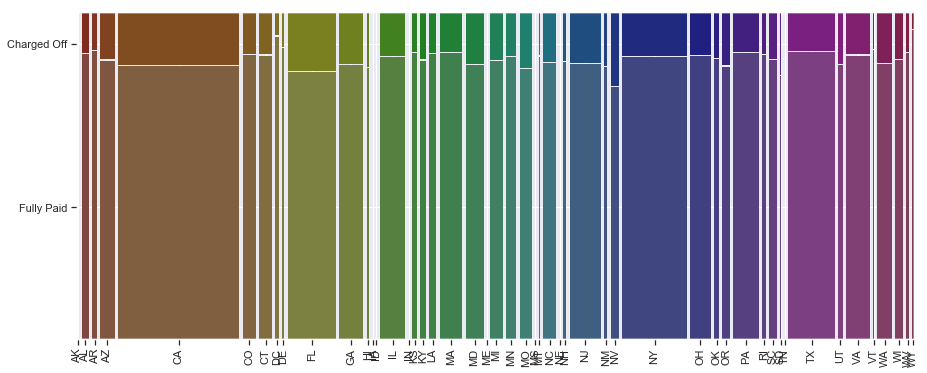

In [35]:
uni_analysis_cat(loan_df[['addr_state' , 'loan_status']] , summary = True)

In [36]:
# chi2 test for addr_state
chi2_cat_pearson(loan_df[['addr_state','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `annual_inc`: The self-reported annual income provided by the borrower during registration

count      38577.00
mean       68777.97
std        64218.68
min         4000.00
25%        40000.00
50%        58868.00
75%        82000.00
max      6000000.00
Name: annual_inc, dtype: float64
****************************************************************************************************


C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


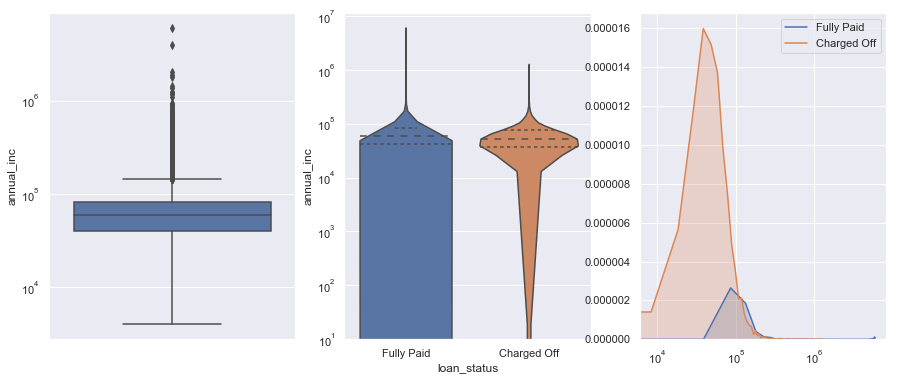

In [37]:
uni_analysis_num(loan_df[['annual_inc', 'loan_status']], log_scale=True)

In [38]:
# Independent T test for annual_income
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].annual_inc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].annual_inc)

p value =  0.0
The 2 sets of data differ significantly


### `verification_status`: Indicates if income was verified by LC, not verified, or if the income source was verified

count            38577
unique               3
top       Not Verified
freq             16694
Name: verification_status, dtype: object
****************************************************************************************************


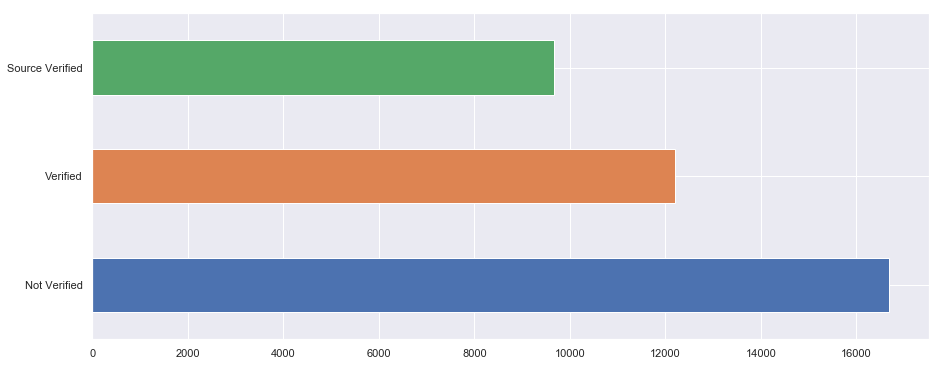

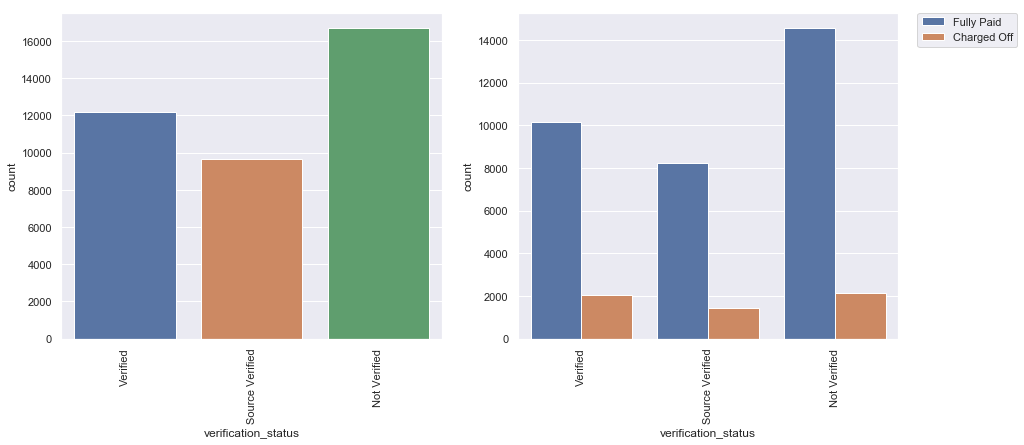

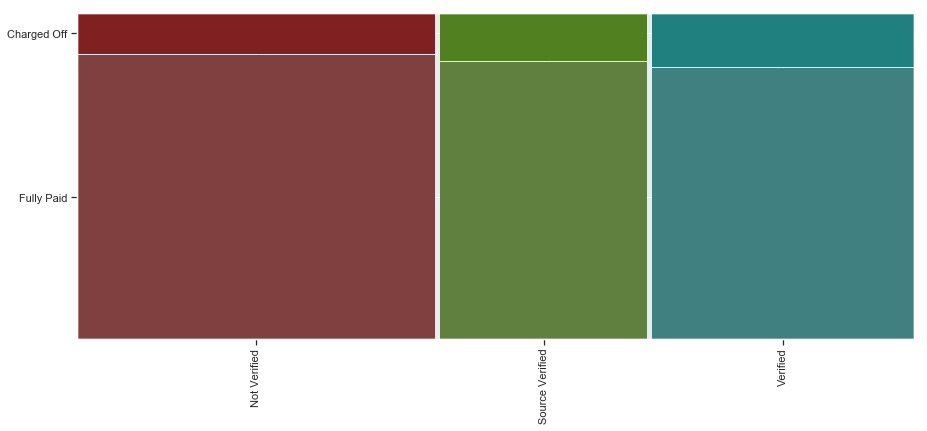

In [39]:
uni_analysis_cat(loan_df[['verification_status', 'loan_status']])

In [40]:
# chi2 test for home_ownership
chi2_cat_pearson(loan_df[['verification_status','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `dti`: A ratio calculated using the borrower’s total monthly debt payments on the total debt obligations, excluding mortgage and the requested LC loan, divided by the borrower’s self-reported monthly income

count    38577.00
mean        13.27
std          6.67
min          0.00
25%          8.13
50%         13.37
75%         18.56
max         29.99
Name: dti, dtype: float64
****************************************************************************************************


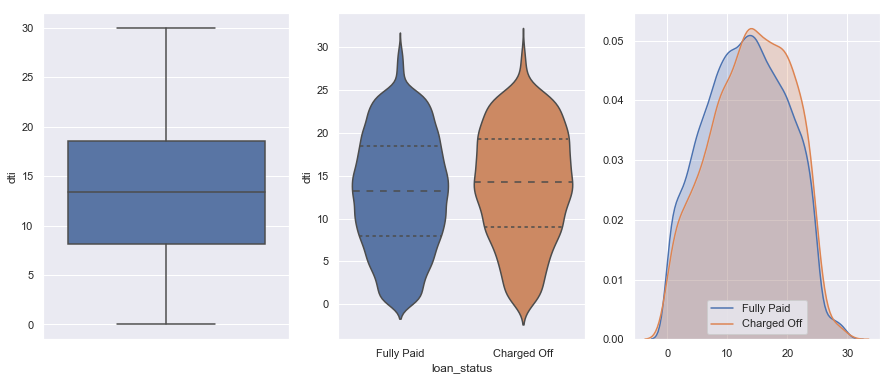

In [41]:
uni_analysis_num(loan_df[['dti', 'loan_status']])

In [42]:
# Independent T test for dti
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].dti ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].dti)

p value =  0.0
The 2 sets of data differ significantly


### `emp_length`: Employment length in years

count         38577
unique           12
top       10+ years
freq           8488
Name: emp_length, dtype: object
****************************************************************************************************


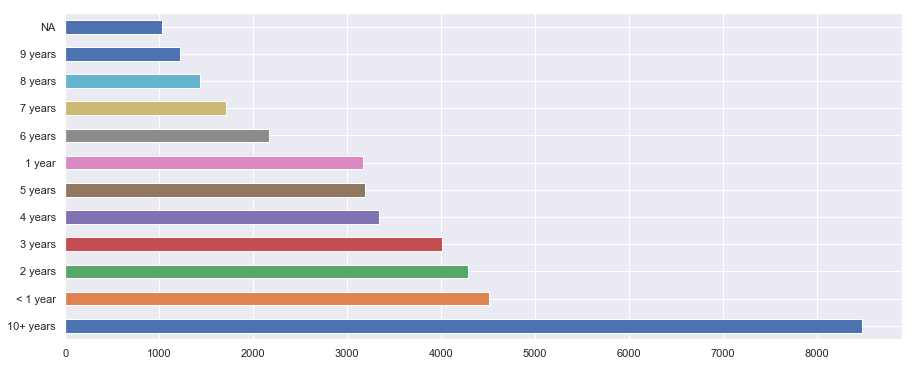

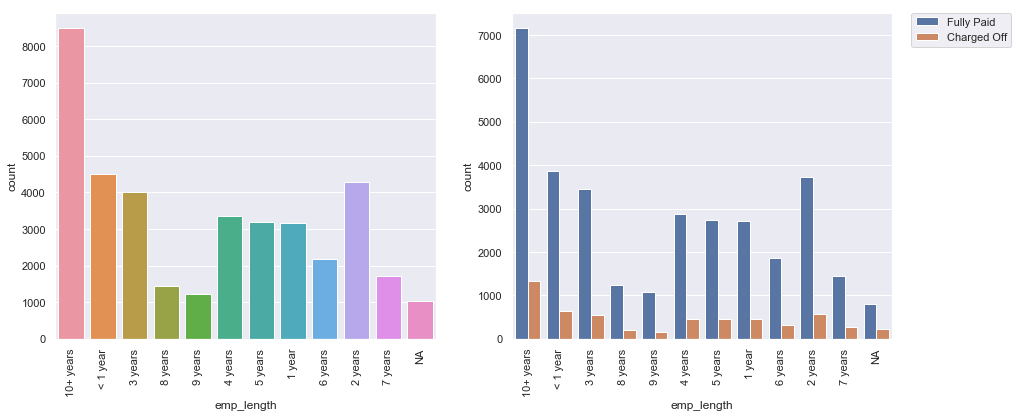

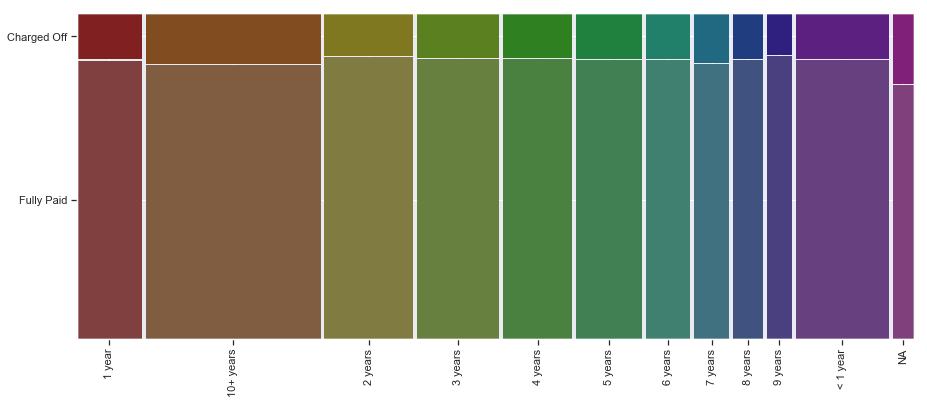

In [43]:
uni_analysis_cat(loan_df[['emp_length', 'loan_status']])

In [44]:
# chi2 test for emp_length
chi2_cat_pearson(loan_df[['emp_length','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `home_ownership`: The home ownership status provided by the borrower during registration

count     38577
unique        5
top        RENT
freq      18480
Name: home_ownership, dtype: object
****************************************************************************************************


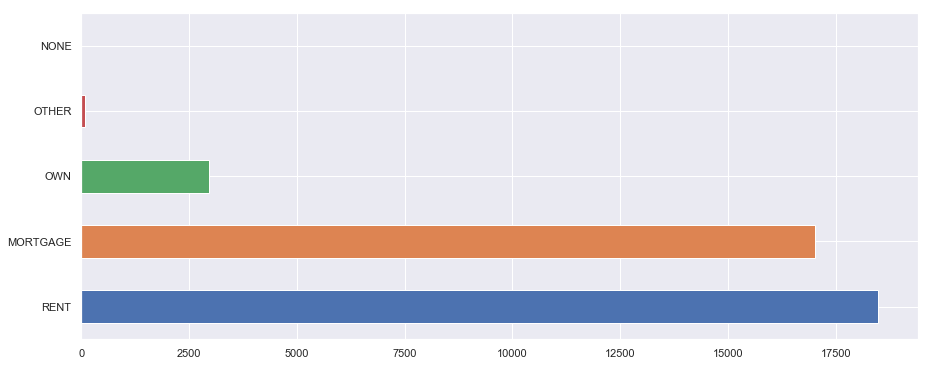

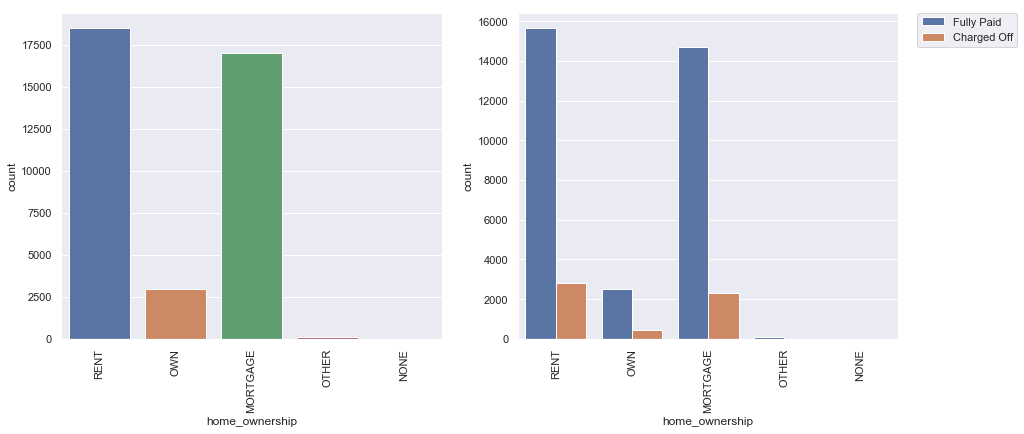

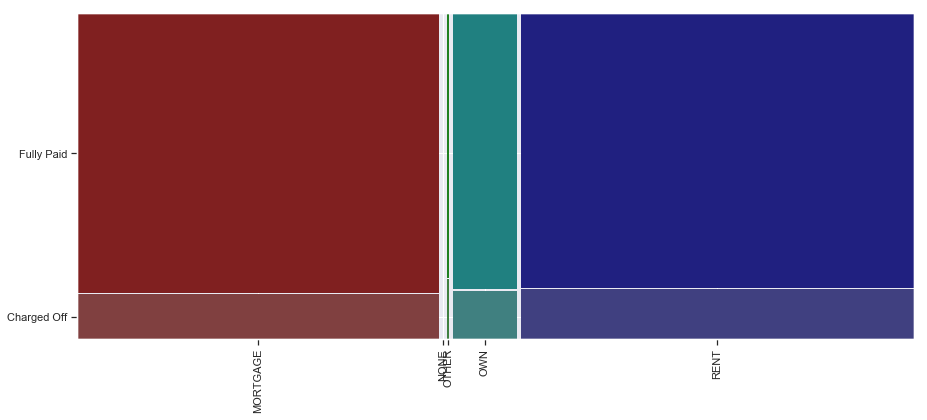

In [45]:
# Univariate analysis of Home ownership and comparison with home status

uni_analysis_cat(loan_df[['home_ownership' , 'loan_status']])

In [46]:
# chi2 test for home_ownership
chi2_cat_pearson(loan_df[['home_ownership','loan_status']])

p value is = 0.0002
The 2 data sets are not independent of each other 


### `mths_since_last_record`: The number of months since the last public record

count    38577.00
mean         3.99
std         21.52
min         -1.00
25%         -1.00
50%         -1.00
75%         -1.00
max        129.00
Name: mths_since_last_record, dtype: float64
****************************************************************************************************


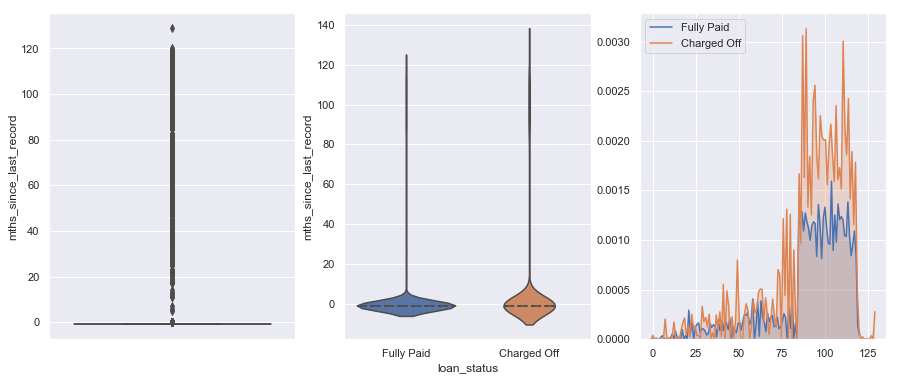

In [47]:
uni_analysis_num(loan_df[['mths_since_last_record', 'loan_status']])

**Business understanding `mths_since_last_record`** 
<br>
The spread for fully paid and charged off loans seams to be same, so distinction cannot be made
further, the values are concetrated between 0 and 20


In [48]:
# Independent T test for mths_since_last_record
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].mths_since_last_record ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].mths_since_last_record)

p value =  0.0
The 2 sets of data differ significantly


### `open_acc`: The number of open credit lines in the borrower's credit file

count    38577.00
mean         9.28
std          4.40
min          2.00
25%          6.00
50%          9.00
75%         12.00
max         44.00
Name: open_acc, dtype: float64
****************************************************************************************************


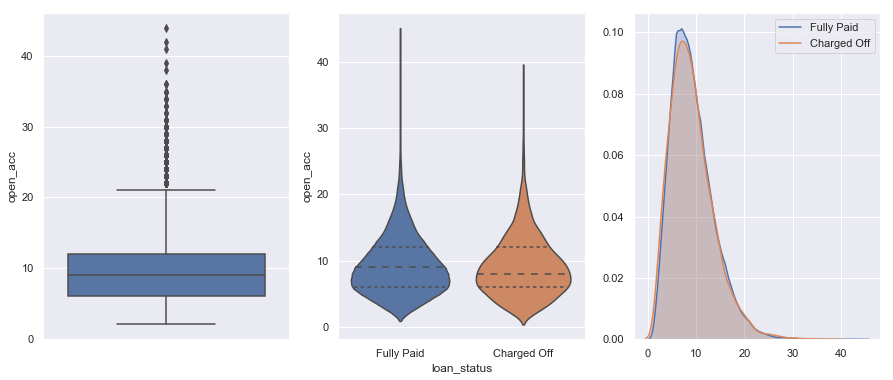

In [49]:
uni_analysis_num(loan_df[['open_acc', 'loan_status']])

__Business understanding after analysing `open_acc`__
<br>
The spread for fully paid and charged off loans seams to be same, so distinction cannot be made

In [50]:
# Independent T test for open_acc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].open_acc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].open_acc)

p value =  0.0795
We cannot state that the 2 sets of data differ significantly


### `total_acc`: The total number of credit lines currently in the borrower's credit file

count    38577.00
mean        22.05
std         11.43
min          2.00
25%         13.00
50%         20.00
75%         29.00
max         90.00
Name: total_acc, dtype: float64
****************************************************************************************************


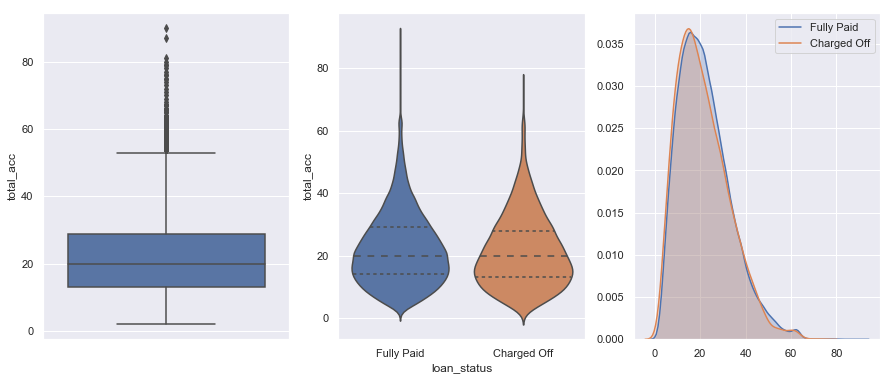

In [51]:
uni_analysis_num(loan_df[['total_acc', 'loan_status']])

In [52]:
# Independent T test for total_acc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].total_acc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].total_acc)

p value =  0.0
The 2 sets of data differ significantly


### `pub_rec`: Number of derogatory public records

count    38577.000000
mean         0.055422
std          0.237804
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          4.000000
Name: pub_rec, dtype: float64
****************************************************************************************************


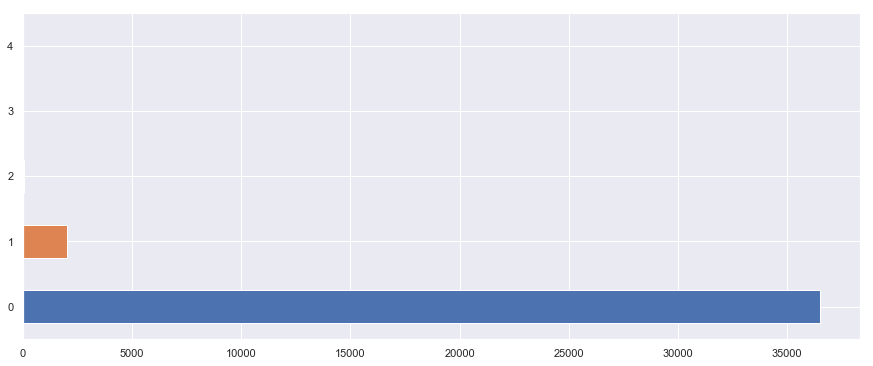

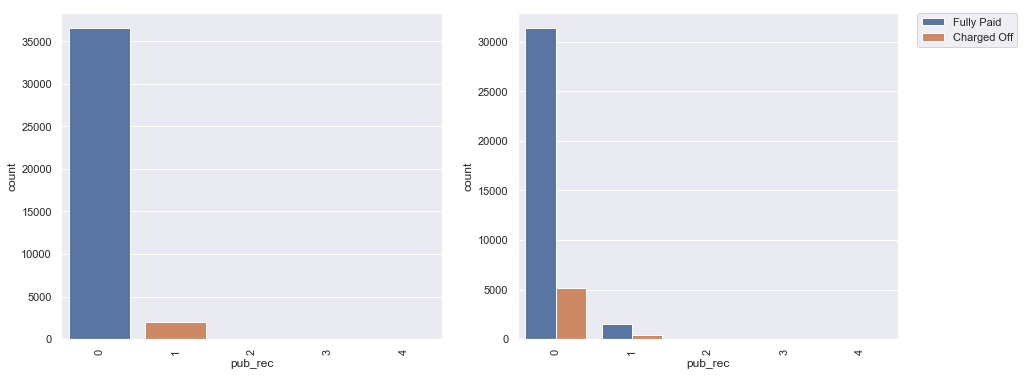

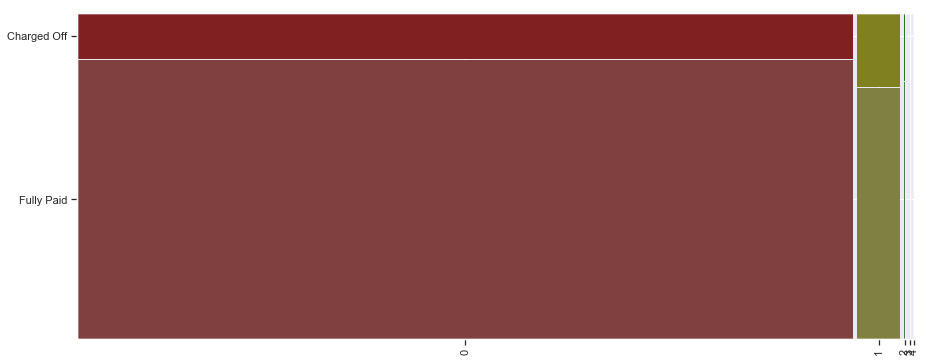

In [53]:
# Doing Univariate analysis 
uni_analysis_cat(loan_df[['pub_rec', 'loan_status']])

In [54]:
propensity_default =loan_df.groupby(['pub_rec','loan_status'])['pub_rec'].count()*100/loan_df.groupby(['pub_rec'])['pub_rec'].count()
propensity_default.sort_values(ascending=False)

pub_rec  loan_status
4        Fully Paid     100.000000
3        Fully Paid     100.000000
0        Fully Paid      85.865724
2        Fully Paid      79.166667
1        Fully Paid      77.297566
         Charged Off     22.702434
2        Charged Off     20.833333
0        Charged Off     14.134276
Name: pub_rec, dtype: float64

__Business understanding after analysing `pub_rec`__
<br>
If the Public record is 1 or 2, there is a high propensity to default

In [55]:
# chi2 test for pub_rec
chi2_cat_pearson(loan_df[['pub_rec','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `pub_rec_bankruptcies`: Number of public record bankruptcies

count    38577.000000
mean         0.042694
std          0.202809
min          0.000000
25%          0.000000
50%          0.000000
75%          0.000000
max          2.000000
Name: pub_rec_bankruptcies, dtype: float64
****************************************************************************************************


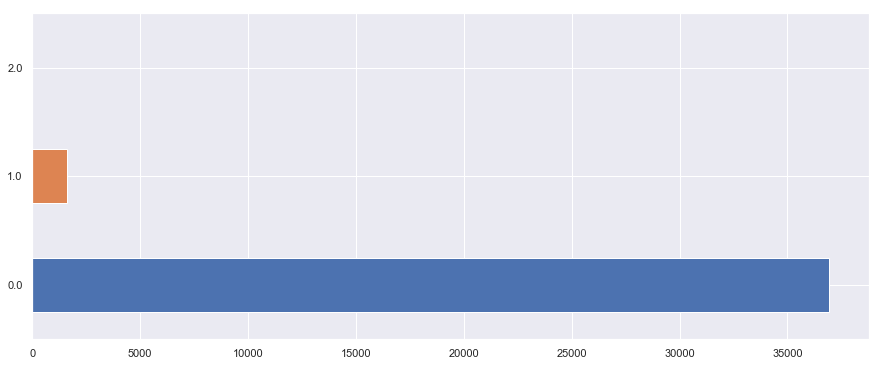

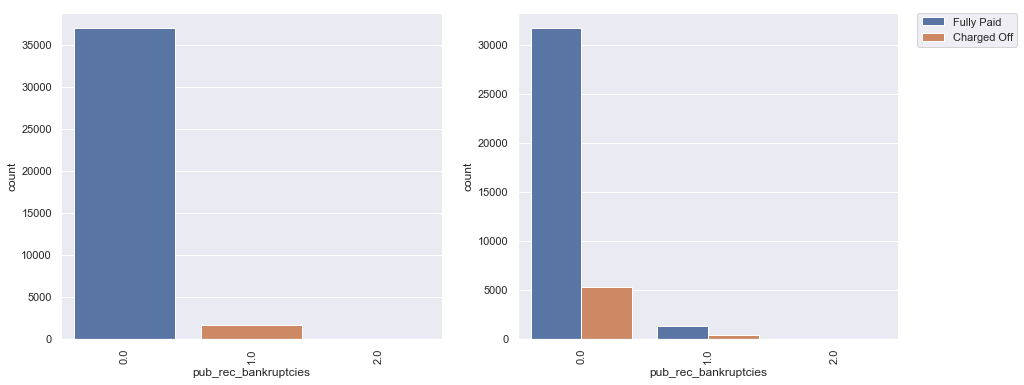

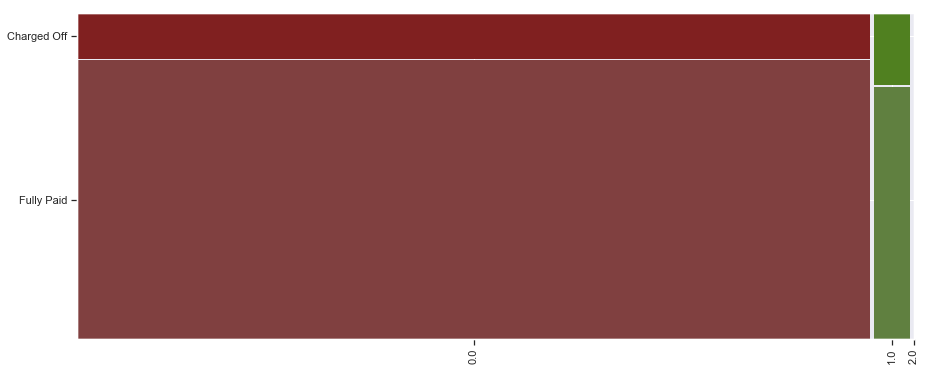

In [56]:
# Doing Univariate analysis 

uni_analysis_cat(loan_df[['pub_rec_bankruptcies', 'loan_status']])

In [57]:
propensity_default =loan_df.groupby(['pub_rec_bankruptcies','loan_status'])['pub_rec_bankruptcies'].count()*100/loan_df.groupby(['pub_rec_bankruptcies'])['pub_rec_bankruptcies'].count()
propensity_default.sort_values(ascending=False)

pub_rec_bankruptcies  loan_status
0.0                   Fully Paid     85.761473
1.0                   Fully Paid     77.642028
2.0                   Fully Paid     60.000000
                      Charged Off    40.000000
1.0                   Charged Off    22.357972
0.0                   Charged Off    14.238527
Name: pub_rec_bankruptcies, dtype: float64

__Business understanding after analysing `pub_rec_bankruptcies`__
<br>

If the Public record is 1 or 2, there is a high propensity to default

In [58]:
# chi2 test for pub_rec_bankruptcies
chi2_cat_pearson(loan_df[['pub_rec_bankruptcies','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


**Understanding if `pub_rec` and `pub_rec_bankruptcies` are correlated**

In [59]:
loan_df[['pub_rec','pub_rec_bankruptcies']].corr()

,pub_rec,pub_rec_bankruptcies
pub_rec,1.000000,0.841571
pub_rec_bankruptcies,0.841571,1.000000


**we can either keep `pub_rec` or `pub_rec_bankruptcies` as the two datasets are correlated**

### `earliest_cr_line`:	The month the borrower's earliest reported credit line was opened

In [60]:
# In case of months , perform analysis based on both month and year 
# start with the setting the date type and then continue with the seperate analysis of Month and year 

loan_df.earliest_cr_line = pd.to_datetime(loan_df.earliest_cr_line , format = '%b-%y')

loan_df['earliest_cr_line_month'] = loan_df.earliest_cr_line.dt.month
loan_df['earliest_cr_line_year'] = loan_df.earliest_cr_line.dt.year.apply(lambda x: x-100 if x > 2019 else x)

count    38577.000000
mean         6.894004
std          3.539057
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: earliest_cr_line_month, dtype: float64
****************************************************************************************************


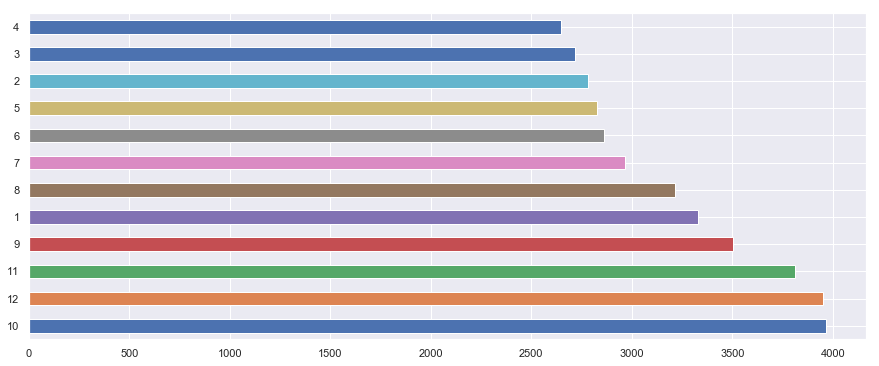

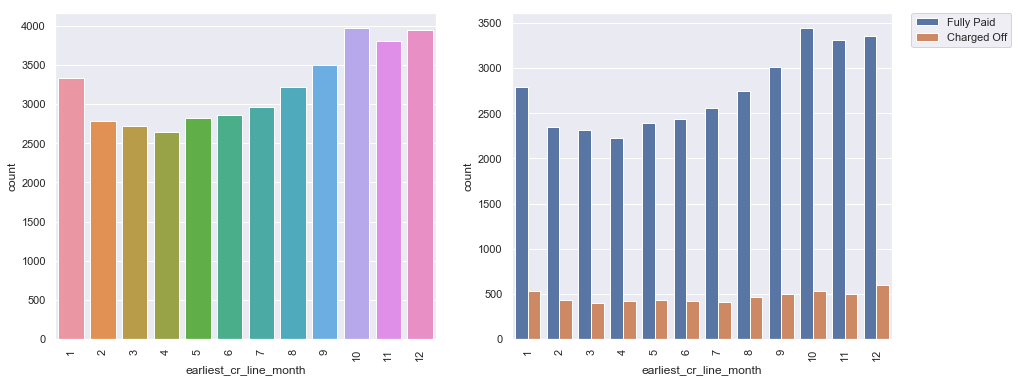

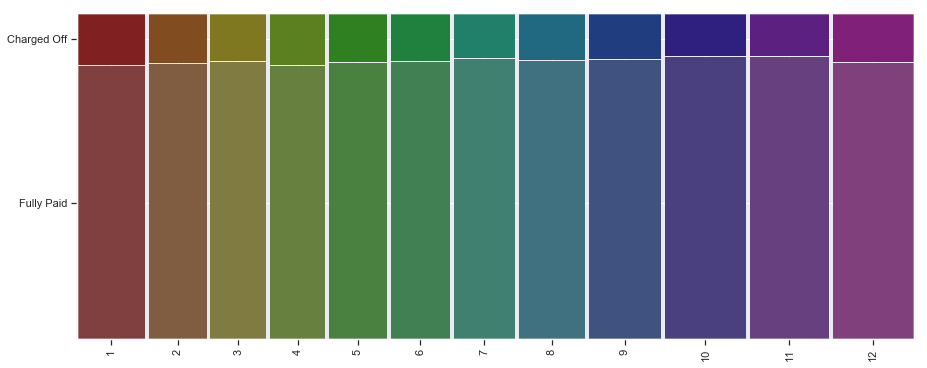

In [61]:
# Univariate analysis considering the month of the loan issue 
# Here we see that delinquency increases witht the later months when loans may have increase just to meet the target numbers

uni_analysis_cat(loan_df[['earliest_cr_line_month' , 'loan_status']] , summary = True)

In [62]:
# chi2 test for 'earliest_cr_line_month
chi2_cat_pearson(loan_df[['earliest_cr_line_month','loan_status']])

p value is = 0.0036
The 2 data sets are not independent of each other 


count    38577.000000
mean      1996.604816
std          6.815696
min       1946.000000
25%       1993.000000
50%       1998.000000
75%       2001.000000
max       2008.000000
Name: earliest_cr_line_year, dtype: float64
****************************************************************************************************


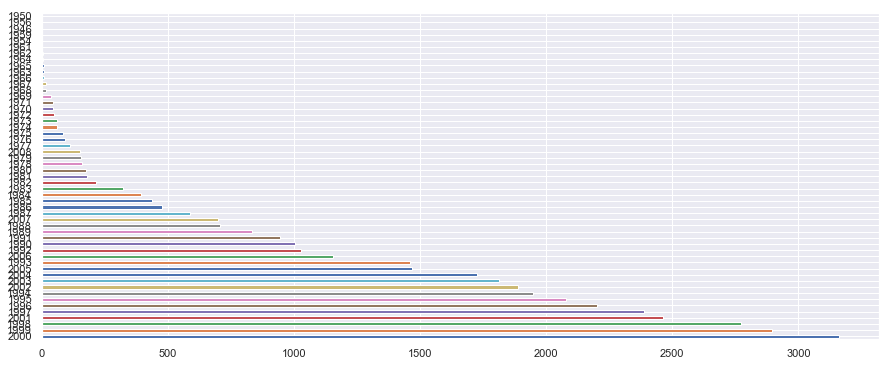

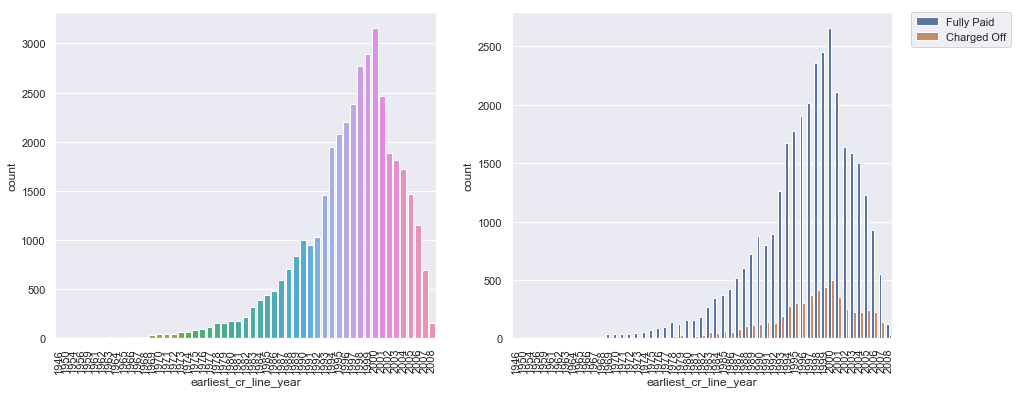

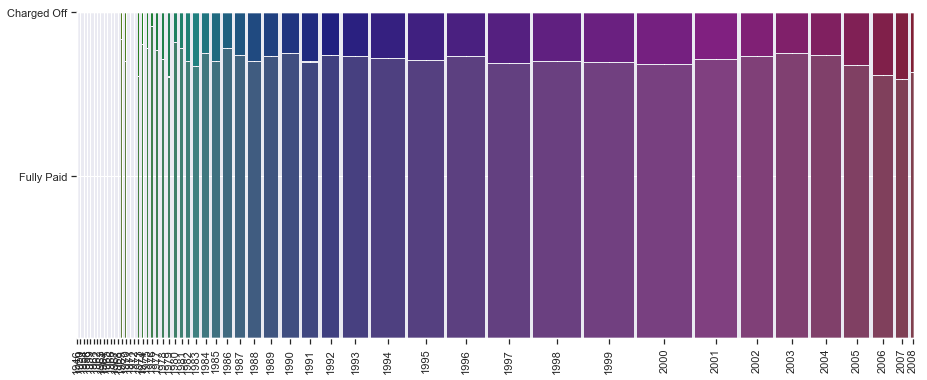

In [63]:
# Univariate analysis considering the month of the loan issue 
# Here we see that delinquency increases witht the later yeas for growth when loans may have increase just to meet the target numbers
# Year 2011 is particularly alarming 

uni_analysis_cat(loan_df[['earliest_cr_line_year' , 'loan_status']])

In [64]:
# chi2 test for earliest_cr_line_year
chi2_cat_pearson(loan_df[['earliest_cr_line_year','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


## Analysis of loan attributes

### `loan_amnt`: The listed amount of the loan applied for by the borrower

count    38577.00
mean     11047.03
std       7348.44
min        500.00
25%       5300.00
50%       9600.00
75%      15000.00
max      35000.00
Name: loan_amnt, dtype: float64
****************************************************************************************************


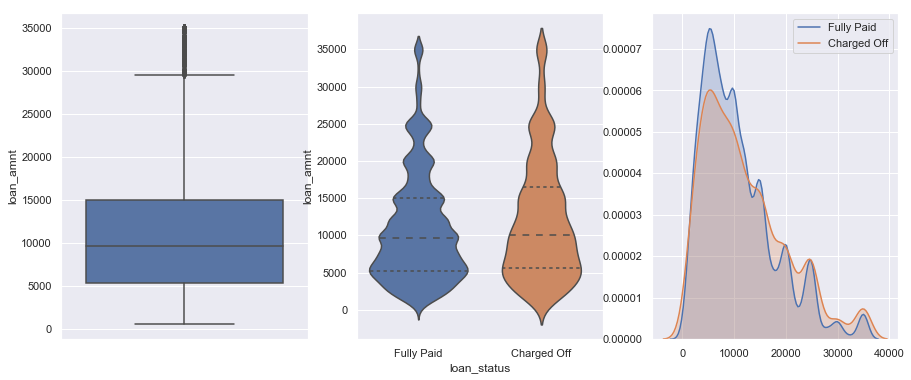

In [65]:
uni_analysis_num(loan_df[['loan_amnt' , 'loan_status']])

In [66]:
# Independent T test for loan_amnt
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].loan_amnt ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].loan_amnt)

p value =  0.0
The 2 sets of data differ significantly


### `installment`: The monthly payment owed by the borrower if the loan originates

count    38577.00
mean       322.47
std        208.64
min         15.69
25%        165.74
50%        277.86
75%        425.55
max       1305.19
Name: installment, dtype: float64
****************************************************************************************************


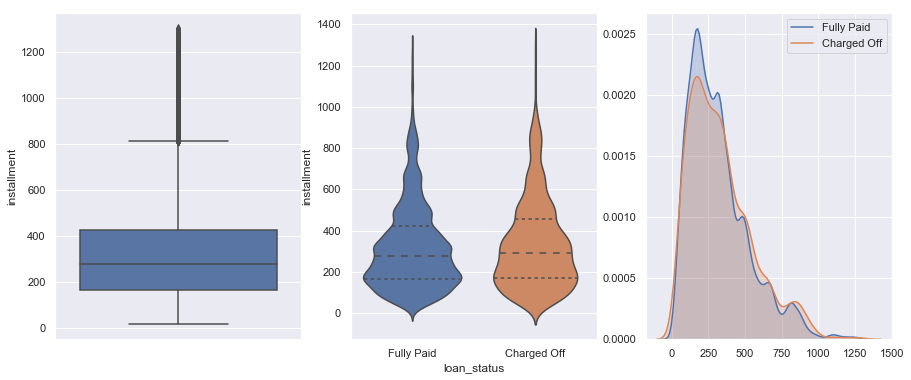

In [67]:
uni_analysis_num(loan_df[['installment' , 'loan_status']])

In [68]:
# Independent T test for installment
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].installment ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].installment)

p value =  0.0
The 2 sets of data differ significantly


### `int_rate`: Interest Rate on the loan

count    38577.00
mean        11.93
std          3.69
min          5.42
25%          8.94
50%         11.71
75%         14.38
max         24.40
Name: int_rate, dtype: float64
****************************************************************************************************


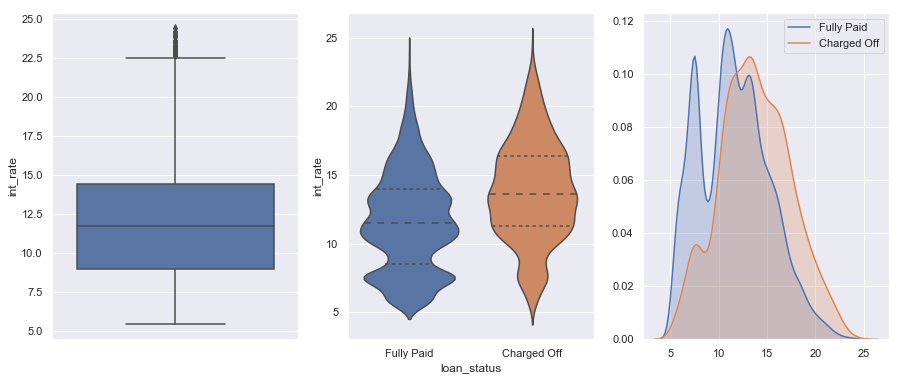

In [69]:
uni_analysis_num(loan_df[['int_rate' , 'loan_status']])

In [70]:
# Independent T test for int_rate
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].int_rate ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].int_rate)

p value =  0.0
The 2 sets of data differ significantly


### `term`: The number of payments on the loan

count    38577.000000
mean        41.898437
std         10.333136
min         36.000000
25%         36.000000
50%         36.000000
75%         36.000000
max         60.000000
Name: term, dtype: float64
****************************************************************************************************


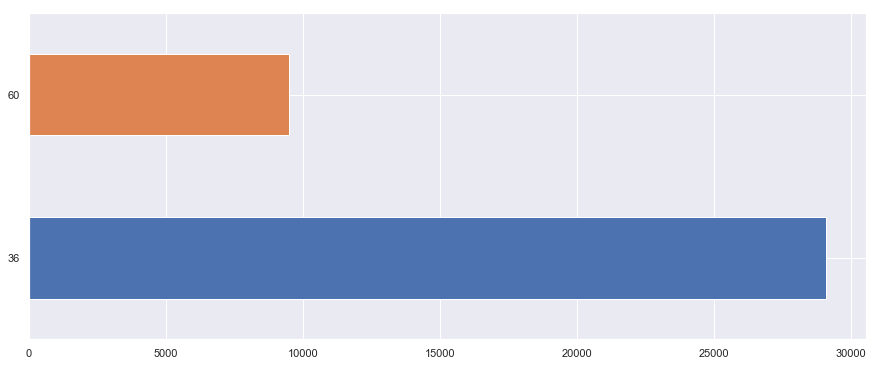

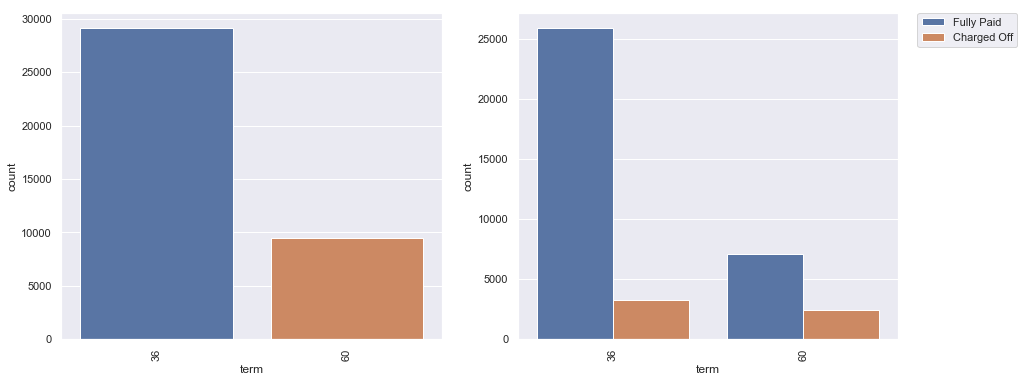

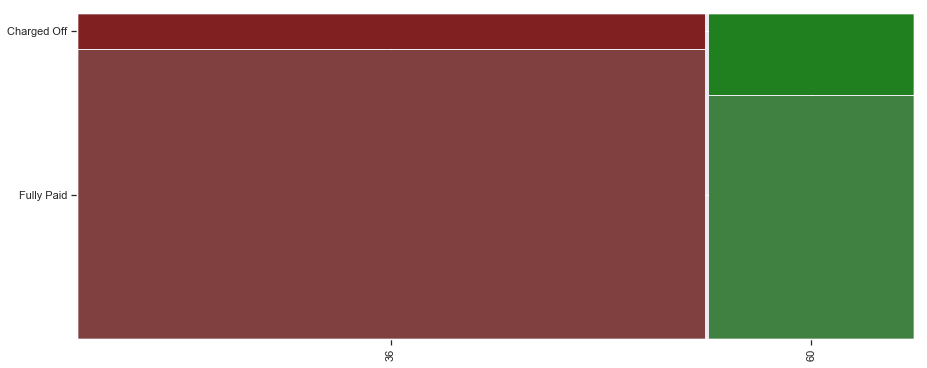

In [71]:
uni_analysis_cat(loan_df[['term' , 'loan_status']])

In [72]:
# chi2 test for term
chi2_cat_pearson(loan_df[['term','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `funded_amnt`: The total amount committed to that loan at that point in time

count    38577.00
mean     10784.06
std       7090.31
min        500.00
25%       5200.00
50%       9550.00
75%      15000.00
max      35000.00
Name: funded_amnt, dtype: float64
****************************************************************************************************


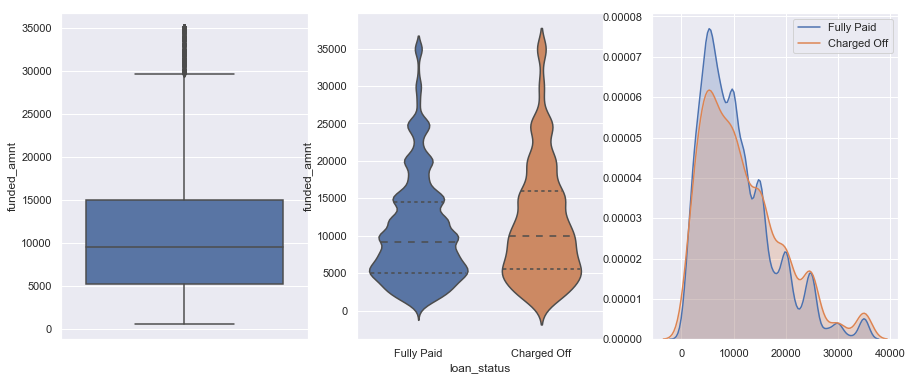

In [73]:
uni_analysis_num(loan_df[['funded_amnt', 'loan_status']])

In [74]:
# Independent T test for funded_amnt
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].funded_amnt ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].funded_amnt)

p value =  0.0
The 2 sets of data differ significantly


### `funded_amnt_inv`: The total amount committed by investors for that loan at that point in time

count    38577.00
mean     10222.48
std       7022.72
min          0.00
25%       5000.00
50%       8733.44
75%      14000.00
max      35000.00
Name: funded_amnt_inv, dtype: float64
****************************************************************************************************


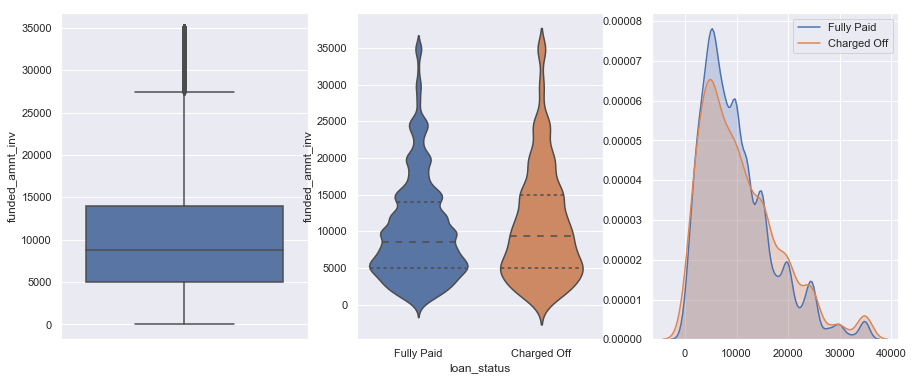

In [75]:
uni_analysis_num(loan_df[['funded_amnt_inv', 'loan_status']])

In [76]:
# Independent T test for annual_income
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].funded_amnt_inv ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].funded_amnt_inv)

p value =  0.0
The 2 sets of data differ significantly


### `grade`: LC assigned loan grade

count     38577
unique        7
top           B
freq      11675
Name: grade, dtype: object
****************************************************************************************************


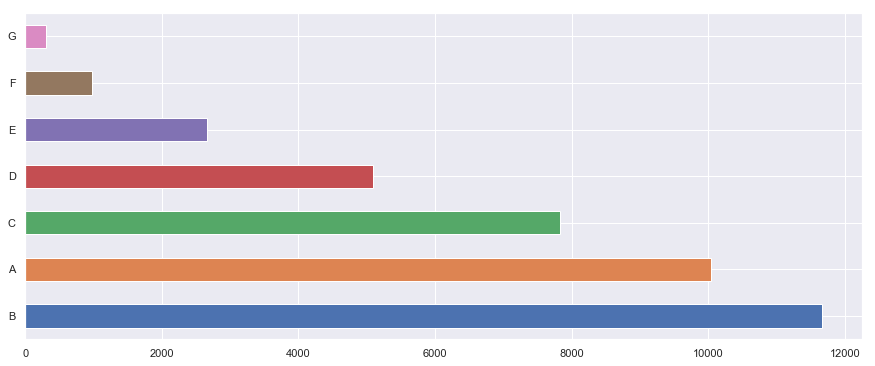

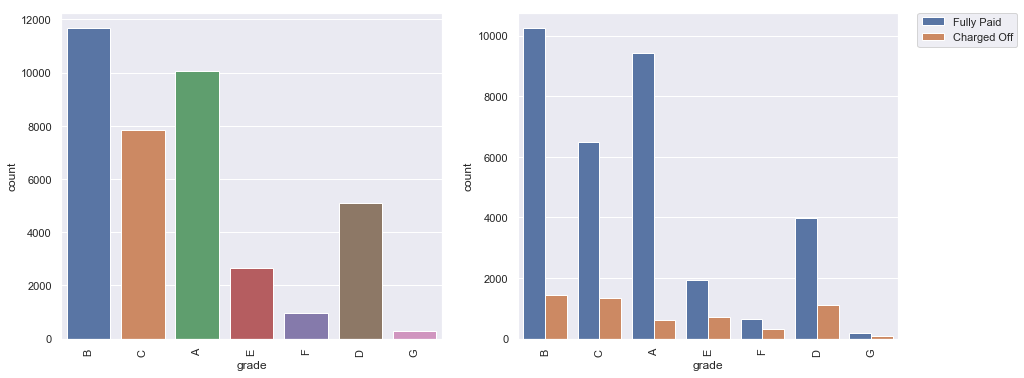

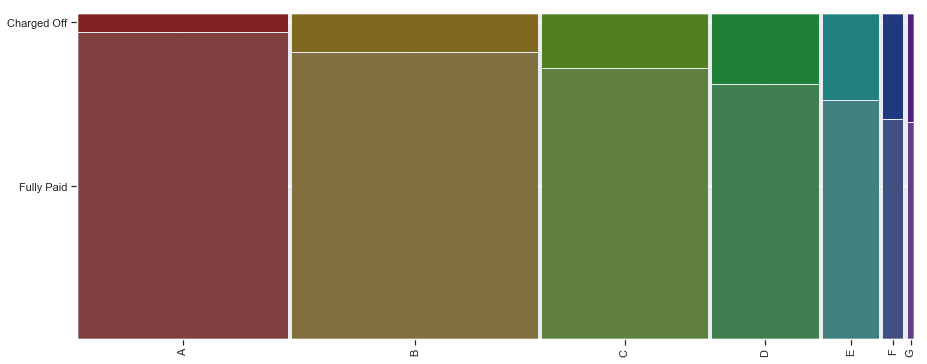

In [77]:
uni_analysis_cat(loan_df[['grade', 'loan_status']])

In [78]:
# chi2 test for grade
chi2_cat_pearson(loan_df[['grade','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `sub_grade`: LC assigned loan subgrade

count     38577
unique       35
top          A4
freq       2873
Name: sub_grade, dtype: object
****************************************************************************************************


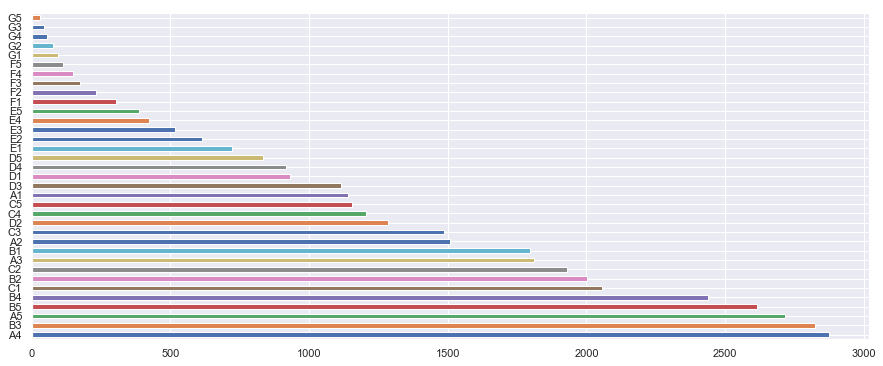

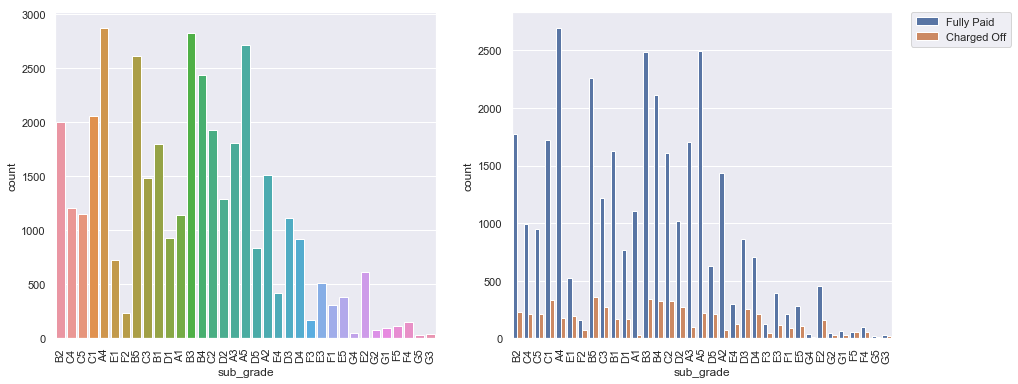

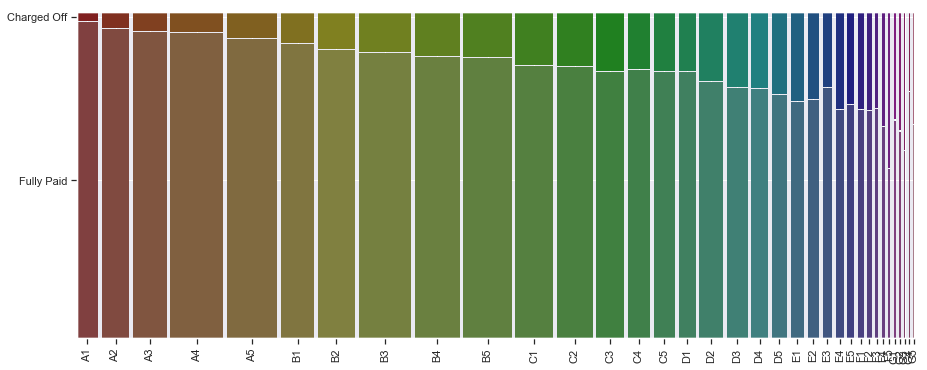

In [79]:
uni_analysis_cat(loan_df[['sub_grade' , 'loan_status']] , summary = True)

In [80]:
# chi2 test for sub_grade
chi2_cat_pearson(loan_df[['sub_grade','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### `purpose`: A category provided by the borrower for the loan request

count                  38577
unique                    14
top       debt_consolidation
freq                   18055
Name: purpose, dtype: object
****************************************************************************************************


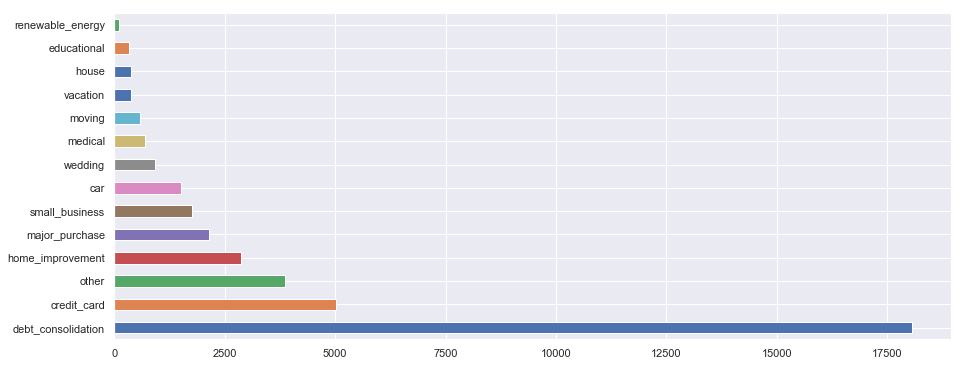

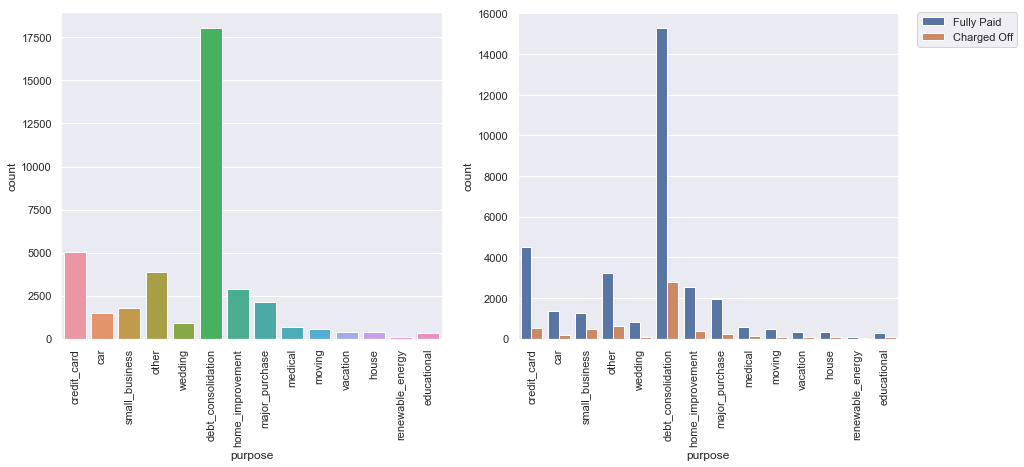

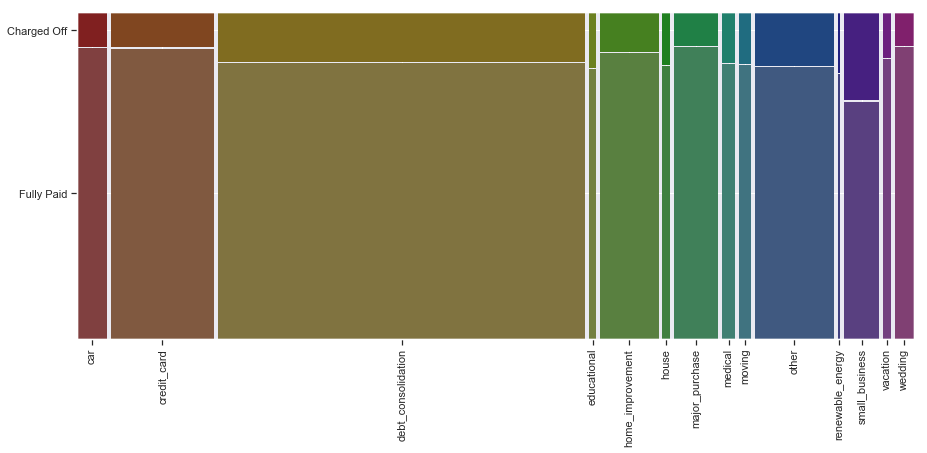

In [81]:
uni_analysis_cat(loan_df[['purpose' , 'loan_status']] , summary = True)

In [82]:
# chi2 test for home_ownership
chi2_cat_pearson(loan_df[['purpose','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


***We can see that small_business, renewable_energy, educational are purposes where the propensity for default is high***   

**Business understanding after analysing `purpose`**

This is an important parameter as it has relevance for Default

### `revol_bal`: Total credit revolving balance

count     38577.00
mean      13289.49
std       15866.49
min           0.00
25%        3650.00
50%        8762.00
75%       16912.00
max      149588.00
Name: revol_bal, dtype: float64
****************************************************************************************************


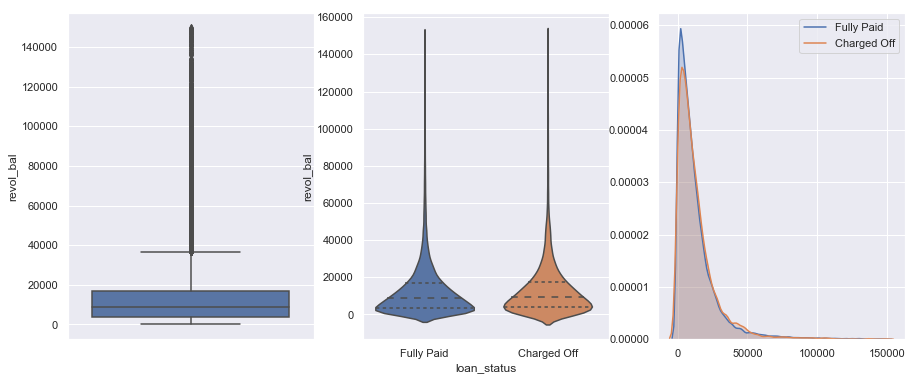

In [83]:
# Doing Univariate analysis 
uni_analysis_num(loan_df[['revol_bal', 'loan_status']])

__Business understanding after analysing `revol_bal`__
<br>
The spread for fully paid and charged off loans seams to be same, so distinction cannot be made



In [84]:
# Independent T test for revol_bal
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].revol_bal ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].revol_bal)

p value =  0.2328
We cannot state that the 2 sets of data differ significantly


### `revol_util`: Revolving line utilization rate, or the amount of credit the borrower is using relative to all available revolving credit

count    38577.00
mean        48.64
std         28.40
min          0.00
25%         25.10
50%         49.00
75%         72.20
max         99.90
Name: revol_util, dtype: float64
****************************************************************************************************


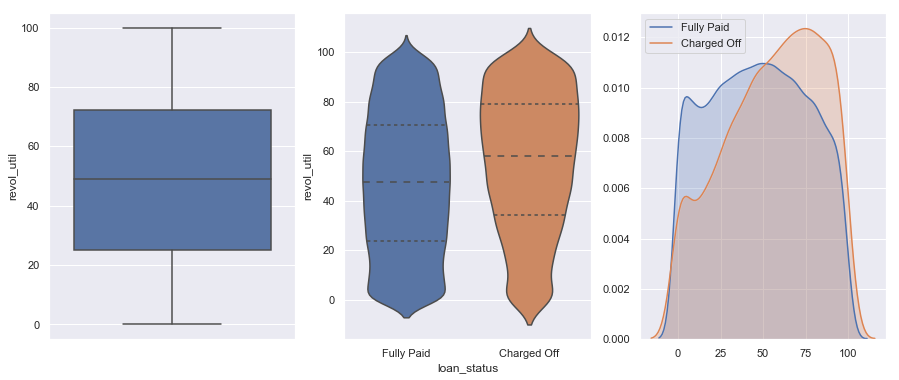

In [85]:
uni_analysis_num(loan_df[['revol_util' , 'loan_status']])


In [86]:
# Independent T test for revol_util
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].revol_util ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].revol_util)

p value =  0.0
The 2 sets of data differ significantly


### `issue_d`: The month which the loan was funded

In [87]:
# In case of months , perform analysis based on both month and year 
# start with the setting the date type and then continue with the seperate analysis of Month and year 

loan_df.issue_d = pd.to_datetime(loan_df.issue_d , format = '%b-%y')

loan_df['issue_d_month'] = loan_df.issue_d.dt.month
loan_df['issue_d_year'] = loan_df.issue_d.dt.year

#Compress the data for the issue date to display the same in the consolidated form based on % 

df_issue_d = loan_df.loc[loan_df.loan_status == 'Charged Off' , ['issue_d_year' , 'issue_d_month' , 'loan_status']]\
            .groupby(['issue_d_year' , 'issue_d_month' , 'loan_status']).size().reset_index()

df_issue_d['status_percent'] = (df_issue_d[0]/sum(df_issue_d[0])).round(4)*100


count    38577.000000
mean         7.114757
std          3.408523
min          1.000000
25%          4.000000
50%          7.000000
75%         10.000000
max         12.000000
Name: issue_d_month, dtype: float64
****************************************************************************************************


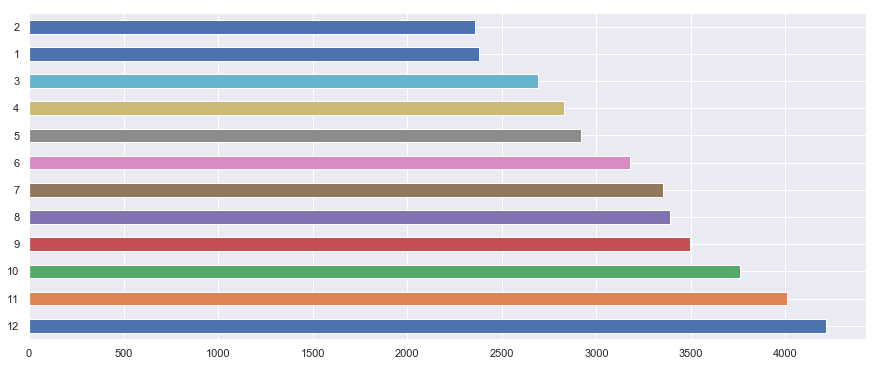

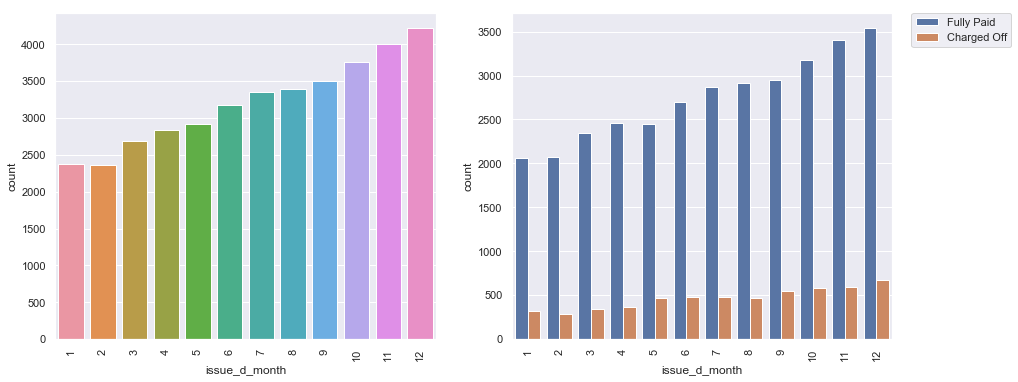

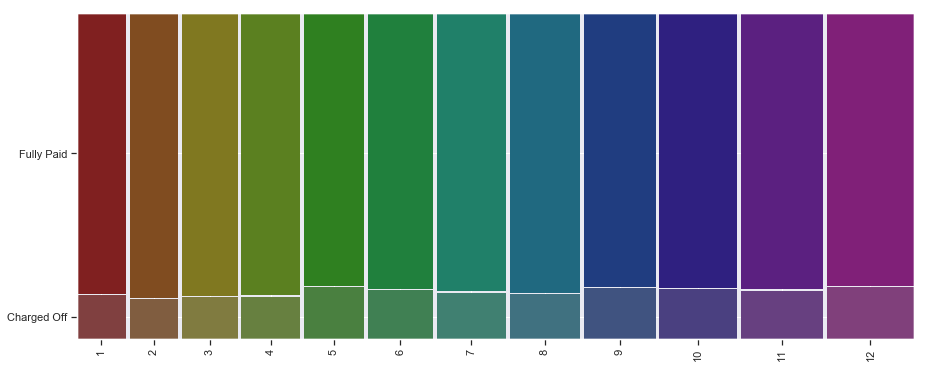

In [88]:
# Univariate analysis considering the month of the loan issue 
# Here we see that delinquency increases witht the later months when loans may have increase just to meet the target numbers

uni_analysis_cat(loan_df[['issue_d_month' , 'loan_status']] , summary = True)

In [89]:
# chi2 test for issue_d_month
chi2_cat_pearson(loan_df[['issue_d_month','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


count    38577.000000
mean      2010.309070
std          0.882658
min       2007.000000
25%       2010.000000
50%       2011.000000
75%       2011.000000
max       2011.000000
Name: issue_d_year, dtype: float64
****************************************************************************************************


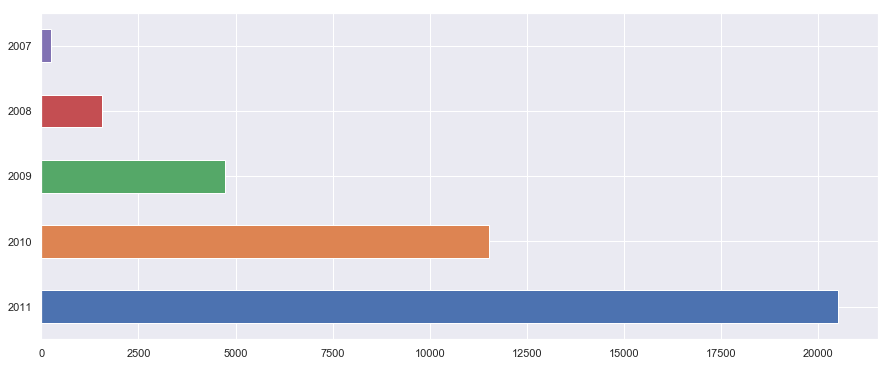

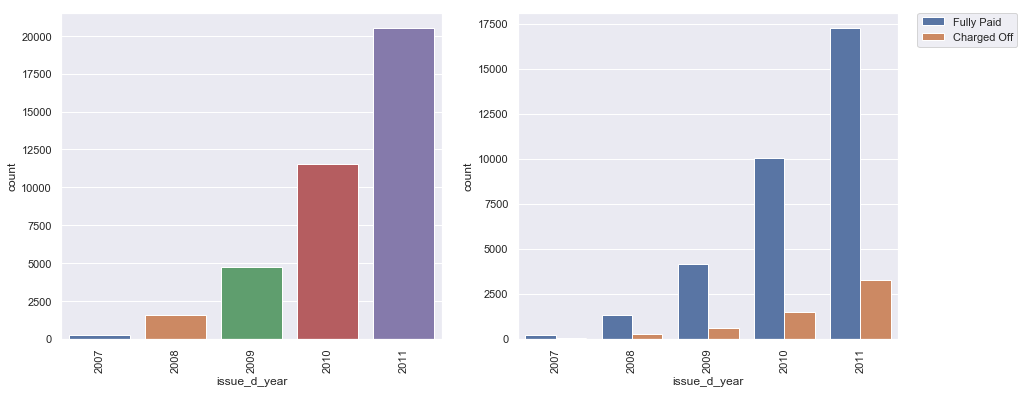

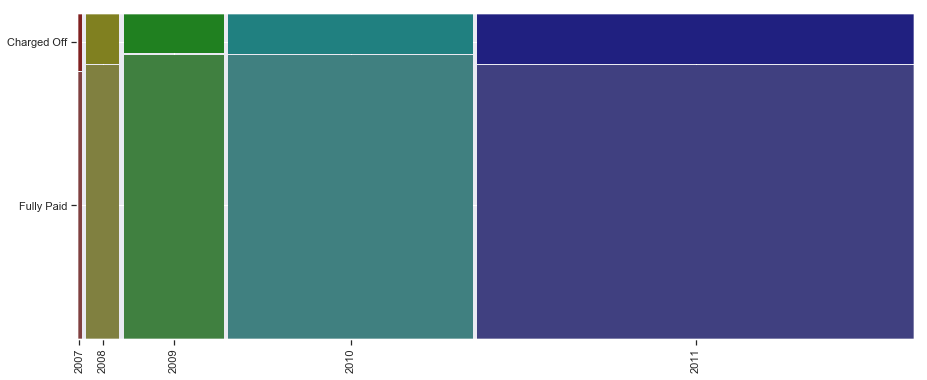

In [90]:
# Univariate analysis considering the month of the loan issue 
# Here we see that delinquency increases witht the later yeas for growth when loans may have increase just to meet the target numbers
# Year 2011 is particularly alarming 

uni_analysis_cat(loan_df[['issue_d_year' , 'loan_status']])

In [91]:
# chi2 test for issue_d_year
chi2_cat_pearson(loan_df[['issue_d_year','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


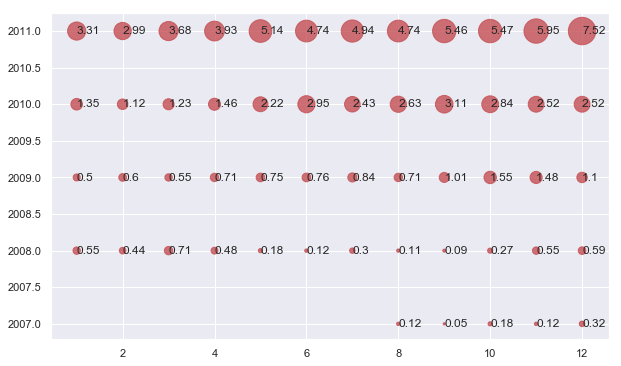

In [92]:
# Undertake the scatter plot for the charged Off variables

bubble_plot(df_issue_d.issue_d_month , df_issue_d.issue_d_year , df_issue_d.loan_status , df_issue_d.status_percent)

### `inq_last_6mths`: The number of inquiries in past 6 months (excluding auto and mortgage inquiries)

count    38577.000000
mean         0.871737
std          1.071546
min          0.000000
25%          0.000000
50%          1.000000
75%          1.000000
max          8.000000
Name: inq_last_6mths, dtype: float64
****************************************************************************************************


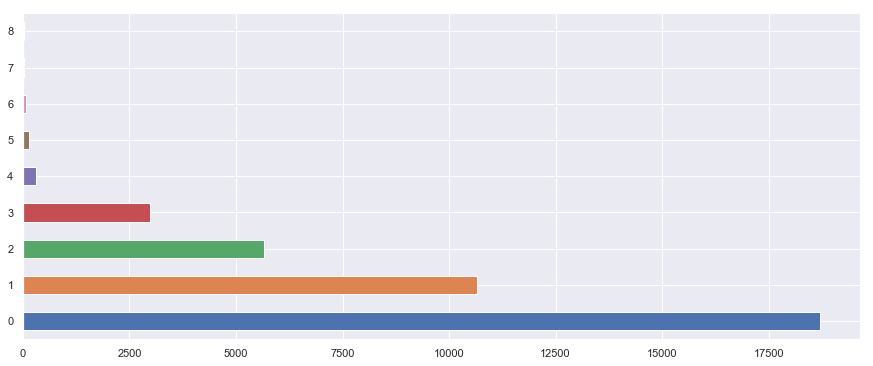

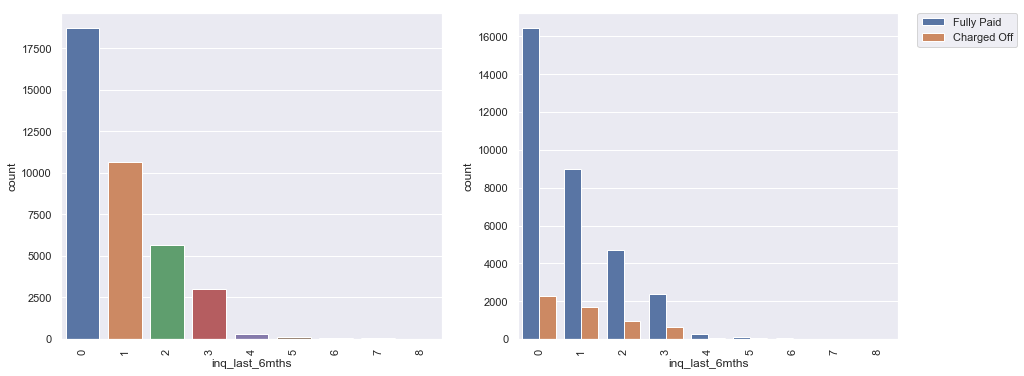

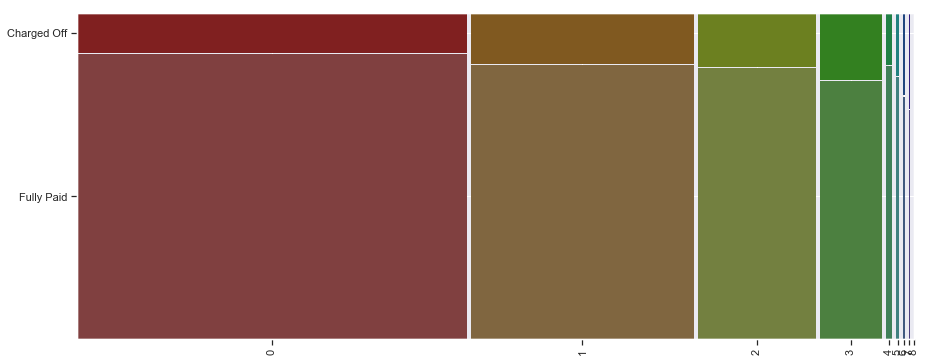

In [93]:
uni_analysis_cat(loan_df[['inq_last_6mths' , 'loan_status']])

In [94]:
# chi2 test for inq_last_6mths
chi2_cat_pearson(loan_df[['inq_last_6mths','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


## Bivariate Analysis

### Correlation Analysis

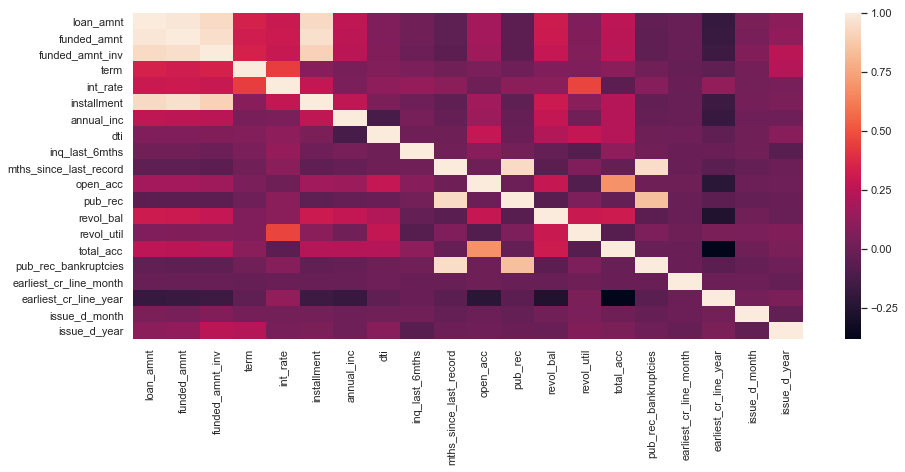

In [95]:
# this is correlation plot for all numeric variables
sns.heatmap(loan_df.corr())

In [96]:
loan_df.corr().style.background_gradient()

,loan_amnt,funded_amnt,funded_amnt_inv,term,int_rate,installment,annual_inc,dti,inq_last_6mths,mths_since_last_record,open_acc,pub_rec,revol_bal,revol_util,total_acc,pub_rec_bankruptcies,earliest_cr_line_month,earliest_cr_line_year,issue_d_month,issue_d_year
loan_amnt,1,0.98179,0.937922,0.34665,0.301265,0.93226,0.268999,0.0624358,0.01294,-0.0440968,0.1772,-0.0499975,0.314022,0.065247,0.256179,-0.0351408,-0.0133517,-0.182124,0.0519024,0.109814
funded_amnt,0.98179,1,0.956172,0.324893,0.30493,0.958035,0.264798,0.0621941,0.0128569,-0.0450441,0.175682,-0.0505762,0.306501,0.0690917,0.250551,-0.0361889,-0.0123696,-0.17526,0.0418525,0.120844
funded_amnt_inv,0.937922,0.956172,1,0.343922,0.297473,0.905464,0.251981,0.070663,-0.00280027,-0.0471814,0.162738,-0.0514702,0.286265,0.0740798,0.242715,-0.036327,-0.0119546,-0.159879,0.0680913,0.252332
term,0.34665,0.324893,0.343922,1,0.440206,0.0904558,0.0438658,0.076182,0.0477079,0.0148981,0.0461625,0.0102661,0.0664109,0.0666585,0.0961683,0.0166903,-0.0155335,-0.0378997,0.0331732,0.237704
int_rate,0.301265,0.30493,0.297473,0.440206,1,0.277203,0.0488991,0.110913,0.133362,0.0942669,0.00602205,0.0986354,0.0941787,0.463627,-0.046539,0.0840158,-0.00764925,0.128793,0.0252851,0.0394166
installment,0.93226,0.958035,0.905464,0.0904558,0.277203,1,0.267842,0.0520385,0.0110144,-0.0411206,0.172893,-0.0457055,0.309501,0.0945593,0.22986,-0.0330383,-0.00903313,-0.15999,0.0294385,0.0530656
annual_inc,0.268999,0.264798,0.251981,0.0438658,0.0488991,0.267842,1,-0.12153,0.0354651,-0.0176706,0.156927,-0.017864,0.277374,0.0174974,0.234534,-0.0159546,-0.0101486,-0.179638,0.00897959,0.00855806
dti,0.0624358,0.0621941,0.070663,0.076182,0.110913,0.0520385,-0.12153,1,0.00217837,0.00437102,0.287849,-0.00474244,0.22809,0.279091,0.229119,0.00731548,0.00884497,-0.0384346,0.0141972,0.0928568
inq_last_6mths,0.01294,0.0128569,-0.00280027,0.0477079,0.133362,0.0110144,0.0354651,0.00217837,1,0.0209267,0.0934343,0.0237263,-0.020787,-0.0700162,0.113516,0.014821,-0.00726957,-0.0082041,0.0133562,-0.0594955
mths_since_last_record,-0.0440968,-0.0450441,-0.0471814,0.0148981,0.0942669,-0.0411206,-0.0176706,0.00437102,0.0209267,1,0.00609323,0.935876,-0.0543542,0.061781,-0.0162151,0.951221,-0.00887857,-0.0548807,-0.0217535,0.000135593


In [97]:
# find columns where they have absolute correlation greater than 0.5 with some other column
corr_matrix = loan_df.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))
to_keep_col = [column for column in upper.columns if any(upper.loc[:,column] >=0.5)]
to_keep_row = [row for row in upper.index if any(upper.loc[row,:] >=0.5)]
to_keep = list(set(to_keep_col).union(set(to_keep_row)))
to_keep

['funded_amnt_inv',
 'total_acc',
 'pub_rec',
 'installment',
 'loan_amnt',
 'mths_since_last_record',
 'pub_rec_bankruptcies',
 'open_acc',
 'funded_amnt']

Lets Focus on these highly correlated columns to derive new features.

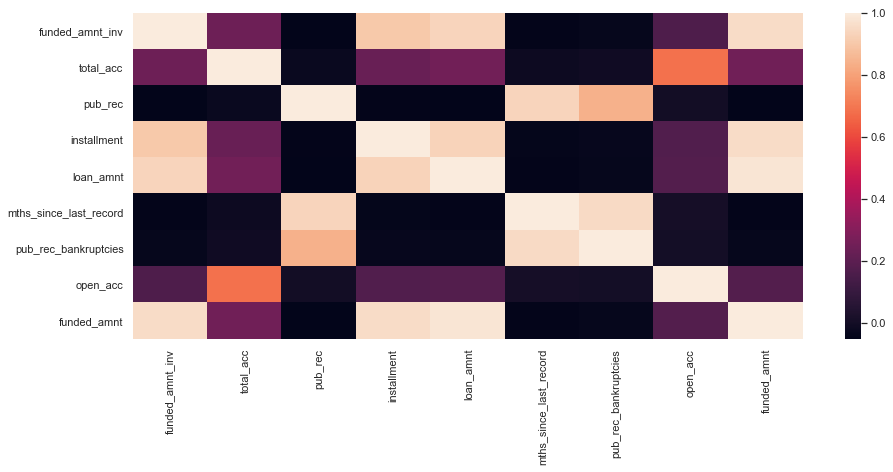

In [98]:
#subset dataframe on highly correlated columns
loan_high_corr_df = loan_df.loc[:,to_keep]
sns.heatmap(loan_high_corr_df.corr())

## Derived Metrics

### Monthly income - binned 

In [99]:
loan_df['monthly_inc'] =  loan_df.annual_inc/12
loan_df['monthly_inc'].describe()

count     38577.000000
mean       5731.497807
std        5351.556817
min         333.333333
25%        3333.333333
50%        4905.666667
75%        6833.333333
max      500000.000000
Name: monthly_inc, dtype: float64

count         38577
unique           12
top       4000-5000
freq           6989
Name: monthly_inc_bins, dtype: object
****************************************************************************************************


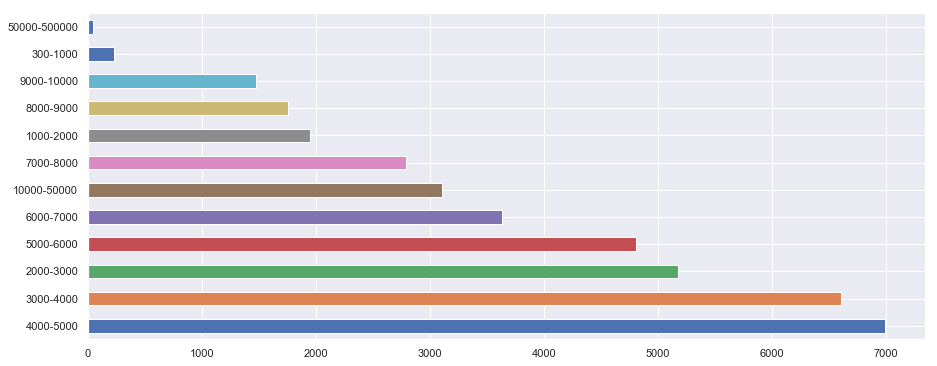

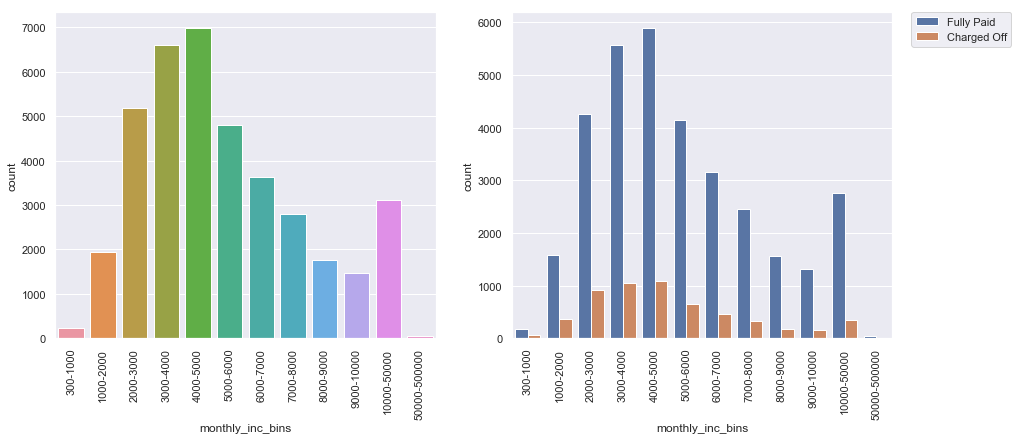

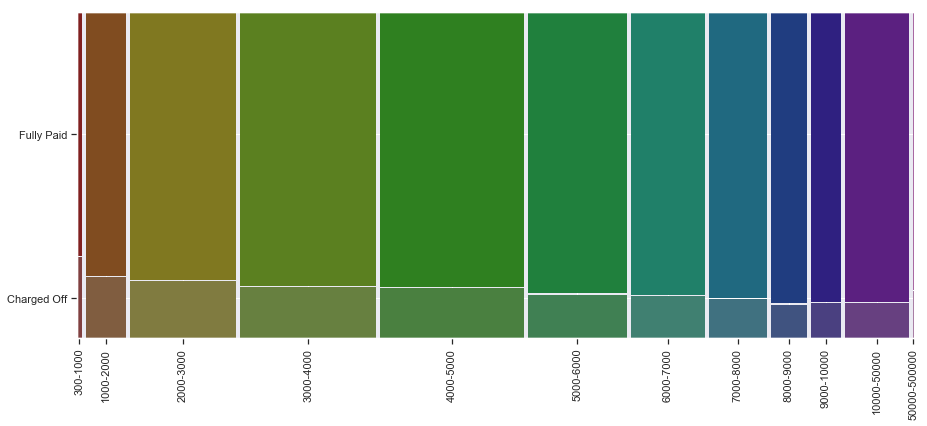

In [100]:
bins = [300, 1000, 2000, 3000, 4000, 5000, 6000, 7000, 8000, 9000, 10000, 50000, 500000]
labels = ['300-1000', 
          '1000-2000', 
          '2000-3000', 
          '3000-4000', 
          '4000-5000', 
          '5000-6000', 
          '6000-7000', 
          '7000-8000', 
          '8000-9000', 
          '9000-10000', 
          '10000-50000', 
          '50000-500000']
loan_df['monthly_inc_bins'] =  pd.cut(loan_df.monthly_inc, bins = bins, labels=labels)
uni_analysis_cat(loan_df[['monthly_inc_bins', 'loan_status']])

In [101]:
# chi2 test for monthly_inc_bins
chi2_cat_pearson(loan_df[['monthly_inc_bins','loan_status']])

p value is = 0.0
The 2 data sets are not independent of each other 


### Loan Amount as Percentage of Annual Income

count    38577.00
mean        18.58
std         11.52
min          0.08
25%          9.80
50%         16.30
75%         25.00
max         83.00
Name: loan_amount_by_annual_inc, dtype: float64
****************************************************************************************************


C:\ProgramData\Anaconda3\envs\upgrad_py_3_6\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


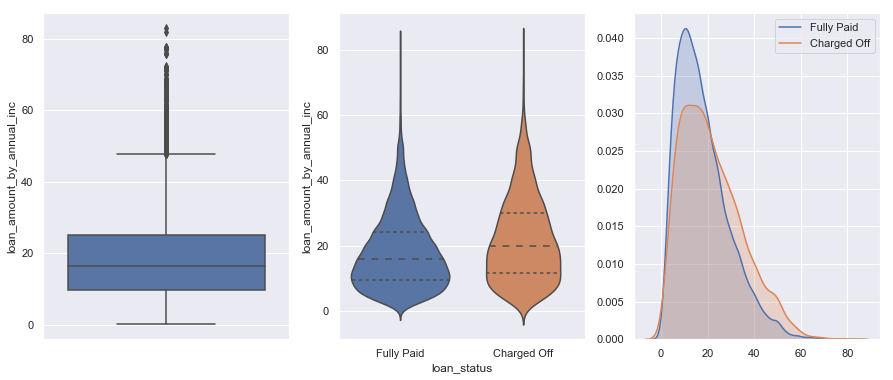

In [102]:
# % of loan amount with respect to annual inc
loan_df['loan_amount_by_annual_inc'] = loan_df.loan_amnt/loan_df.annual_inc*100
uni_analysis_num(loan_df[['loan_amount_by_annual_inc', 'loan_status']])

In [103]:
# Independent T test for loan_amount_by_annual_inc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].loan_amount_by_annual_inc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].loan_amount_by_annual_inc)

p value =  0.0
The 2 sets of data differ significantly


### Annual Installment as Percentage of Annual Income

count    38577.00
mean         6.56
std          4.01
min          0.03
25%          3.50
50%          5.77
75%          8.81
max         32.03
Name: annual_installment_by_annual_inc, dtype: float64
****************************************************************************************************


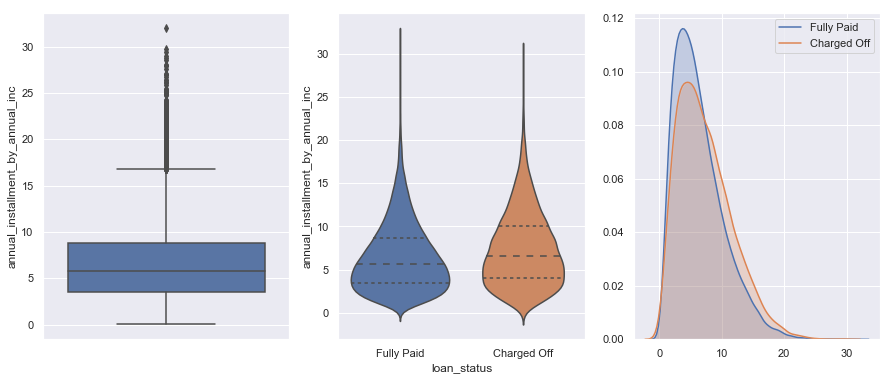

In [104]:
# % of loan installment with respect to monthly income
loan_df['annual_installment_by_annual_inc'] = ((loan_df.installment * 12)/loan_df.annual_inc)*100
uni_analysis_num(loan_df[['annual_installment_by_annual_inc', 'loan_status']])

In [105]:
# Independent T test for annual_installment_by_annual_inc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].annual_installment_by_annual_inc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].annual_installment_by_annual_inc)

p value =  0.0
The 2 sets of data differ significantly


### Surplus amount per month without considering current loan installment

count     38577.00
mean       5014.17
std        5144.29
min         294.98
25%        2895.33
50%        4151.50
75%        5969.34
max      499950.00
Name: surplus_amount_per_month, dtype: float64
****************************************************************************************************


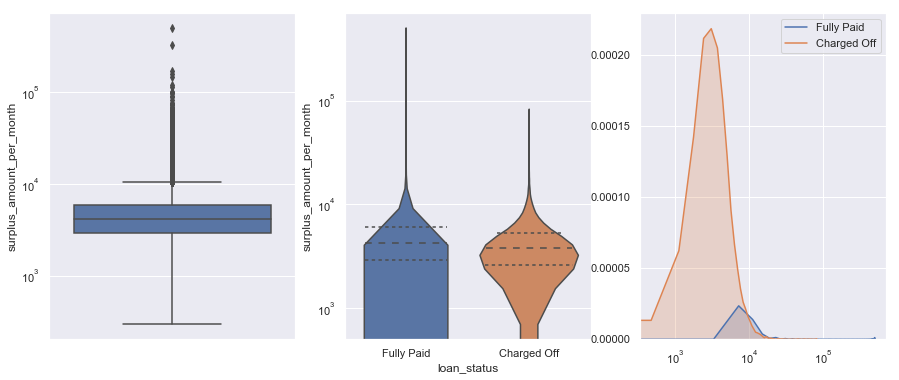

In [106]:
# Surplus amount per month without considering current loan installment
loan_df['surplus_amount_per_month'] = (1 - (loan_df.dti/100)) * loan_df.annual_inc/12
uni_analysis_num(loan_df[['surplus_amount_per_month', 'loan_status']], log_scale=True)

In [107]:
# Independent T test for surplus_amount_per_month
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].surplus_amount_per_month ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].surplus_amount_per_month)

p value =  0.0
The 2 sets of data differ significantly


### Funded amount as proportion to Loan amount

count    38577.00
mean         0.99
std          0.07
min          0.10
25%          1.00
50%          1.00
75%          1.00
max          1.00
Name: funded_amnt_by_loan_amnt, dtype: float64
****************************************************************************************************


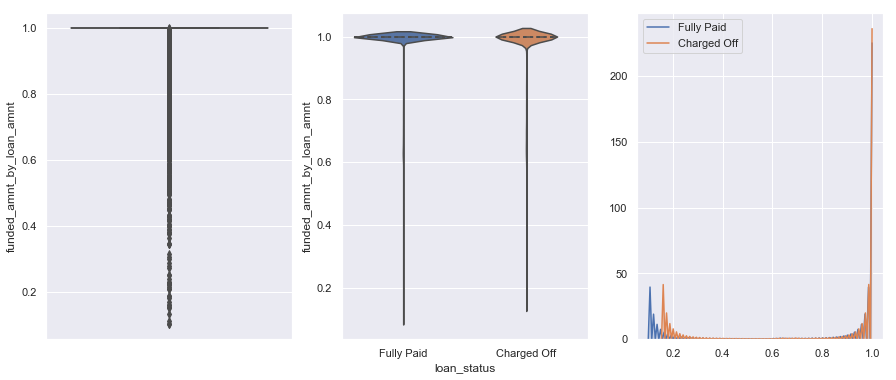

In [108]:
loan_df['funded_amnt_by_loan_amnt'] = loan_df.funded_amnt/loan_df.loan_amnt
uni_analysis_num(loan_df[['funded_amnt_by_loan_amnt', 'loan_status']])

In [109]:
# Independent T test for funded_amnt_by_loan_amnt
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].funded_amnt_by_loan_amnt ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].funded_amnt_by_loan_amnt)

p value =  0.0006
The 2 sets of data differ significantly


### Open_acc in proportion of total_acc

In [110]:
# derived matrix based on open_acc and total_acc
loan_df['open_acc_by_total_acc'] = loan_df.open_acc/loan_df.total_acc

count    38577.00
mean         0.47
std          0.19
min          0.05
25%          0.33
50%          0.44
75%          0.58
max          1.75
Name: open_acc_by_total_acc, dtype: float64
****************************************************************************************************


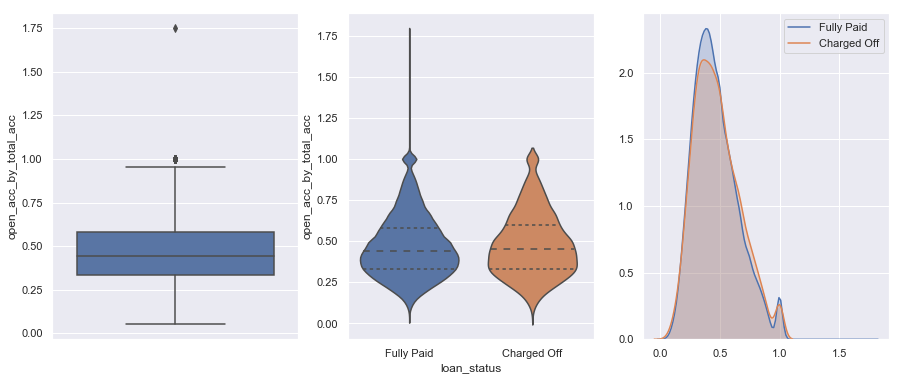

In [111]:
uni_analysis_num(loan_df[['open_acc_by_total_acc', 'loan_status']])

In [112]:
# Independent T test for open_acc_by_total_acc
independant_ttest(loan_df[loan_df.loan_status == "Charged Off"].open_acc_by_total_acc ,\
                  loan_df[loan_df.loan_status == "Fully Paid"].open_acc_by_total_acc)

p value =  0.0
The 2 sets of data differ significantly


The derived matrix open_acc_by_total_acc suggest nothing in particular, as distribution is similar to open_acc 